<a href="https://colab.research.google.com/github/avarela1963/CIFO_PROJECT_GROUP_3/blob/main/Group57_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook Table of Contents**

## Notebook Table of Contents

1. [Initial Setup and Data Loading](#1-initial-setup-and-data-loading)

2. [Categorical Variable Exploration and Cleaning](#2-categorical-variable-exploration-and-cleaning)

3. [Numerical Variable Exploration and Cleaning](#3-numerical-variable-exploration-and-cleaning)

4. [Missing Values Exploration](#4-missing-values-exploration)

5. [Data Split and Preprocessing Pipeline](#5-data-split-and-preprocessing-pipeline)

6. [Feature Selection](#6-feature-selection)

7. [Model Selection](#7-model-selection)

8. [Extra Trees — Final Hyperparameter Tuning](#8-extra-trees--final-hyperparameter-tuning)

9. [Model Blending](#9-model-blending)

10. [Analytics Interface for New-Data Inference](#10-analytics-interface-for-new-data-inference)



### Group Member Contribution — Group 57

**20211548 – Carlos Amorim**  
Exploratory data analysis and data cleaning, ensuring data quality and consistency for modeling.  
Estimated contribution: **25%**

**20250468 – Rodrigo Andrade**  
Design and implementation of preprocessing strategies, supporting consistent data preparation and model training.  
Estimated contribution: **25%**

**20250468 – Francisco Cerdeira**  
Development of the first prototype for preprocessing and feature selection, supporting model evaluation.  
Estimated contribution: **25%**

**2014553 – António Varela**  
Model selection, hyperparameter tuning, ensemble definition, and development of the analytics interface and inference pipeline.  
Estimated contribution: **25%**


### Abstract

The price of a used car is influenced by multiple factors such as age, mileage, brand, fuel type, and technical characteristics, making accurate price estimation a complex task. The objective of this project is to develop a consistent model assessment strategy that allows the creation and comparison of different candidate regression models in order to identify the most generalizable one for predicting car prices.

The work started with an exploratory analysis of the dataset to understand feature distributions and identify data quality issues. A major challenge during data preparation was the cleaning of categorical variables, particularly brand and model names, which contained numerous inconsistencies and misspellings. To address this, a hybrid fuzzy string matching approach was applied, combining Euclidean distance and Levenshtein distance to standardise equivalent values. Missing data was handled using appropriate imputation methods, while numerical features were scaled and categorical features were encoded. The dataset was split into training and test sets, with all model training, comparison, and hyperparameter tuning performed exclusively on the training data.

In total, six different regression models were developed and evaluated using a consistent assessment strategy, enabling a fair comparison of their performance and generalisation capability. The best results, in terms of Mean Absolute Error (MAE), were achieved using a blended model combining Extra Trees, Random Forest, and Histogram Gradient Boosting. In addition, an analytics interface was created using Gradio, allowing users to input new vehicle data and instantly receive a predicted price from the trained model.

Future work may focus on feature engineering, expanding the dataset, and improving the user interface to make it more user-friendly and robust.


In [1]:
"""
README — Cars4You Machine Learning Pipeline
===========================================

Computational Requirements
--------------------------
This notebook contains the complete Cars4You machine learning pipeline, covering
all stages from data preparation to model inference and user interaction.

The pipeline includes computationally intensive steps such as high-dimensional
one-hot encoding, ensemble tree models, and final model blending. For this reason,
the full pipeline was executed using Google Colab with a high-memory runtime.

Minimum recommended resources to execute the full pipeline:
- RAM: at least 52 MB
- CPU: standard multi-core environment
- Execution time: several minutes, depending on the runtime configuration

Running the entire pipeline on machines with lower memory availability may result
in kernel interruptions or incomplete execution.

--------------------------------------------------

Input Data Requirements
-----------------------
The execution of this pipeline requires the availability of the original dataset
files provided with the project:

- `train.csv`: loaded in **Section 1**, used for data exploration, preprocessing,
  model training, and validation.
- `test.csv`: loaded in **Section 8**, used exclusively for final inference and
  generation of test predictions.

Both files must be accessible in the runtime environment before executing the
corresponding sections of the notebook.

--------------------------------------------------

Project Requirements and Compliance
-----------------------------------
This project was designed to meet the specified requirements of the assignment.
In particular, it explicitly satisfies requirement (c):

"Create an analytics interface that returns a prediction when new input data is
provided."

This requirement is fulfilled through:
- a inference function that applies the original, leakage-safe
  preprocessing pipeline to new, unseen data
- consistent reuse of trained artifacts, including encoders, imputation values,
  and the final feature space
- an interactive analytics interface that allows users to input new car data and
  obtain price predictions

The analytics interface provides predictions from multiple trained models as well
as a weighted ensemble prediction, together with a visual comparison of model
outputs.

--------------------------------------------------

Note to the Reader
------------------
This notebook reflects a complete end-to-end workflow, from raw data processing to
a user-facing analytics interface. The pipeline is intentionally structured to
clearly separate training, inference, and interaction layers, ensuring clarity,
reproducibility, and ease of evaluation.

This README describes the current state of the project and may be updated in future
iterations to reflect optimizations or additional deployment considerations.
"""


'\nREADME — Cars4You Machine Learning Pipeline\n===========================================\n\nComputational Requirements\n--------------------------\nThis notebook contains the complete Cars4You machine learning pipeline, covering\nall stages from data preparation to model inference and user interaction.\n\nThe pipeline includes computationally intensive steps such as high-dimensional\none-hot encoding, ensemble tree models, and final model blending. For this reason,\nthe full pipeline was executed using Google Colab with a high-memory runtime.\n\nMinimum recommended resources to execute the full pipeline:\n- RAM: at least 52 MB\n- CPU: standard multi-core environment\n- Execution time: several minutes, depending on the runtime configuration\n\nRunning the entire pipeline on machines with lower memory availability may result\nin kernel interruptions or incomplete execution.\n\n--------------------------------------------------\n\nInput Data Requirements\n-----------------------\nThe e

# **1. Initial Setup and Data Loading**

In [2]:
# =========================================
#  1) Instalação de pacotes necessários
# =========================================
!pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.8 MB/s eta 0:00:00


In [3]:
# =========================================
# 2) Importações — Organização por tema
# =========================================

# ---- Manipulação de dados
import pandas as pd
import numpy as np

# ---- Similaridade / fuzzy matching
from rapidfuzz import process, fuzz, distance

# ---- Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Pré-processamento
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
    LabelEncoder
)

# ---- Estatística
import scipy.stats as stats
from scipy.stats import chi2_contingency, f_oneway

# ---- Feature Selection
from sklearn.feature_selection import (
    mutual_info_classif,
    mutual_info_regression,
    RFE
)

# ---- Modelos
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# ---- Métricas
from sklearn.metrics import (
    mean_squared_error,
    make_scorer,
    r2_score,
    mean_absolute_error
)

# ---- Validação e splits
from sklearn.model_selection import (
    train_test_split,
    KFold,
    RepeatedKFold
)

# ---- Reprodutibilidade
import random

# ---- Upload (Google Colab)
from google.colab import files


# =========================================
#  3) Fixar Random Seed
# =========================================
RANDOM_SEED = 1907
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
# =========================================
#  4) Upload do dataset via Colab
# =========================================
uploaded = files.upload()  # O utilizador escolhe o ficheiro manualmente


# =========================================
# 5) Carregar e inspecionar os dados
# =========================================
df = pd.read_csv("train.csv")  # Nome do ficheiro depois do upload
print("\nArquivo carregado:", "train.csv")

# =========================================
#  TOY MODE (opcional)
# =========================================
USE_TOY = False   # <-- Mude para False para usar o dataset completo

if USE_TOY:
    print("\n TOY MODE ATIVO — utilizando apenas 1000 linhas para testes.")
    df = df.sample(n=1000, random_state=42).reset_index(drop=True)
else:
    print("\nFULL MODE — utilizando todas as linhas do train.csv.")

# Mostrar forma do dataset usado
print("\nDataset carregado com shape:", df.shape)

# Guardar cópia original para referência
og_df = df.copy()

# Mostrar primeiras linhas
display(df)

# Estrutura do DataFrame
print("\n=== df.info() ===")
df.info()

# Estatísticas descritivas
print("\n=== df.describe() ===")
display(df.describe())



Saving train.csv to train.csv

Arquivo carregado: train.csv

FULL MODE — utilizando todas as linhas do train.csv.

Dataset carregado com shape: (75973, 14)


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
3,29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75968,37194,Mercedes,C Class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
75969,6265,Audi,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
75970,54886,Toyota,Aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0
75971,860,Audi,Q3,2015.0,12990,Manual,69072.0,iesel,125.0,60.100000,2.0,74.0,2.000000,0.0



=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB

=== df.describe() ===


,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,75973.000000,74482.000000,75973.000000,74510.000000,68069.000000,68047.000000,74457.000000,74449.000000,74423.000000,74425.0
mean,37986.000000,2017.096611,16881.889553,23004.184088,120.329078,55.152666,1.660136,64.590667,1.994580,0.0
std,21931.660338,2.208704,9736.926322,22129.788366,65.521176,16.497837,0.573462,21.021065,1.472981,0.0
min,0.000000,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,18993.000000,2016.000000,10200.000000,7423.250000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,37986.000000,2017.000000,14699.000000,17300.000000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,56979.000000,2019.000000,20950.000000,32427.500000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,75972.000000,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


In [5]:
df["carID"].duplicated().any()

np.False_

In [6]:

def carID_como_index(df):
    df = df.copy()
    df = df.set_index("carID")
    return df

df=carID_como_index(df)
display(df)

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,Golf,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,Yaris,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2 Series,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,Mercedes,C Class,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
6265,Audi,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
54886,Toyota,Aygo,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0


# **2. Categorical Variable Exploration and Cleaning**

## **2.1 Brand Feature Exploration and Cleaning**

In [7]:
df["Brand"].unique()

array(['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes',
       'FOR', 'mercedes', 'Hyundai', 'w', 'ord', 'MW', 'bmw', nan,
       'yundai', 'BM', 'Toyot', 'udi', 'Ope', 'AUDI', 'V', 'opel', 'pel',
       'For', 'pe', 'Mercede', 'audi', 'MERCEDES', 'OPEL', 'koda', 'FORD',
       'Hyunda', 'W', 'Aud', 'vw', 'hyundai', 'skoda', 'ford', 'TOYOTA',
       'ercedes', 'oyota', 'toyota', 'SKODA', 'Skod', 'HYUNDAI', 'kod',
       'v', 'for', 'SKOD', 'aud', 'KODA', 'PEL', 'yunda', 'or', 'UDI',
       'OYOTA', 'HYUNDA', 'mw', 'OPE', 'mercede', 'ERCEDES', 'ercede',
       'TOYOT', 'MERCEDE', 'ORD', 'ud', 'ope', 'AUD', 'hyunda', 'skod',
       'toyot'], dtype=object)

In [8]:
df["Brand"].value_counts()

,count
Brand,
Ford,14808
Mercedes,10754
VW,9780
Opel,8645
BMW,6968
...,...
OYOTA,2
SKOD,1
TOYOT,1


In [9]:
df[df["Brand"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
66591,NaN,T-Roc,2018.0,23000,Semi-Auto,584.0,Petrol,150.0,41.5,2.0,79.0,1.0,0.0
5034,NaN,A3,2016.0,11871,Manual,52519.0,Diesel,20.0,72.4,1.6,60.0,2.0,0.0
33153,NaN,I20,2020.0,13966,MANUAL,3500.0,Petrol,145.0,47.9,1.0,41.0,2.0,0.0
45338,NaN,CL Class,2020.0,54995,Semi-Auto,NaN,Petrol,145.0,33.2,2.0,61.0,4.0,0.0
66712,NaN,POLO,2016.0,8650,Manual,32800.0,Petrol,20.0,60.1,1.0,54.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72615,NaN,Golf,2015.0,11750,Manual,79000.0,Diesel,20.0,67.3,2.0,68.0,0.0,0.0
3436,NaN,Q5,2015.0,21995,Semi-Auto,18188.0,Diesel,200.0,47.1,2.0,84.0,3.0,0.0
7392,NaN,A5,2019.0,31490,Automatic,10.0,Petrol,145.0,39.8,2.0,70.0,1.0,0.0


In [10]:
def HELPER_marca_correta(marca, marcas_dict, threshold):
    if not isinstance(marca, str) or marca.strip() == "": #Check type and emptiness & Lowercase and strip:
        return marca

    result = process.extractOne(
        marca.lower().strip(),
        marcas_dict.keys(),
        scorer=fuzz.token_sort_ratio
    )

    #result = (match, score, index)
    #ex: match = toyota, score = 94.5, index = 1 (qual das marcas no dicionário é mais semelhante)

    if result is None:
        return marca

    match_lower, score, _ = result
    return marcas_dict[match_lower] if score >= threshold else marca #Score check



In [11]:
def fuzzy_marcas(df, threshold=50):
    df=df.copy()

    valid_brands = ["VW", "Toyota", "Audi", "Ford", "BMW", "Opel", "Skoda", "Mercedes", "Hyundai"]
    brands_dict = {BRAND.lower(): BRAND for BRAND in valid_brands}

    df["Brand"] = df["Brand"].apply(lambda x: HELPER_marca_correta(x, brands_dict, threshold))
    return df

In [12]:
df=fuzzy_marcas(df)
df["Brand"].unique()

array(['VW', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel', 'Mercedes',
       'Hyundai', nan], dtype=object)

In [13]:
df["Brand"].value_counts()

,count
Brand,
Ford,16063
Mercedes,11674
VW,10385
Opel,9352
BMW,7392
Audi,7325
Toyota,4622
Skoda,4303
Hyundai,3336


## **2.2 MODEL Feature Exploration and Cleaning**

In [14]:
df["model"].unique()

array([' Golf', ' Yaris', ' Q2', ' FIESTA', ' 2 Series', '3 Series',
       ' A3', ' Octavia', ' Passat', ' Focus', ' Insignia', ' A Clas',
       ' Q3', ' Fabia', ' A Class', ' Ka+', ' 3 Series', ' GLC Class',
       ' I30', ' C Class', ' Polo', ' E Class', ' C Clas', ' Q5', ' Up',
       ' Fiesta', ' C-HR', ' Mokka X', ' Corsa', ' Astra', ' TT',
       ' 5 Series', ' Aygo', ' 4 Series', ' SLK', ' Viva', ' T-Roc',
       'Focus', ' EcoSport', ' Tucson', ' EcoSpor', nan, ' X-CLASS',
       ' CL Class', ' IX20', ' i20', ' Rapid', ' a1', ' Auris', ' sharan',
       ' I20', ' Adam', ' X3', ' A8', ' GLS Class', ' B-MAX', ' A4',
       ' Kona', ' I10', ' A1', ' Mokka', ' fiesta', ' S-MAX', ' X2',
       ' Crossland X', ' Tiguan', ' A5', ' GLE Class', ' C CLASS',
       ' mokka x', ' Zafira', ' Ioniq', ' A6', ' Mondeo', ' Yeti Outdoor',
       ' X1', 'POLO', ' INSIGNIA', ' Scala', ' S Class', ' 1 Series',
       ' Kamiq', ' Kuga', ' Tourneo Connect', ' Q7', ' GLA Class',
       ' Arteon', ' 

In [15]:
len(df["model"].unique())

736

In [16]:
# group models by brand
grouped = df.groupby("Brand")["model"].value_counts()

display(grouped["Hyundai"])


,count
model,
Tucson,821
I10,671
I30,352
I20,307
Kona,213
Ioniq,185
Santa Fe,135
IX20,129
I40,78


In [17]:
"""Optained through meticulous ChatGPT prompt engineering"""
valid_models = {
    "Audi": [
        "A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8",
        "Q2", "Q3", "Q5", "Q7", "Q8",
        "TT", "T", "R8",
        "S3", "S4", "S5", "S8",
        "RS3", "RS4", "RS5", "RS6",
        "SQ5", "SQ7"
    ],

    "Ford": [
        "FOCUS", "FIESTA", "MONDEO", "KA", "KA+", "FUSION",
        "KUGA", "ECOSPORT", "EDGE", "PUMA",
        "CMAX", "BMAX", "SMAX", "GALAXY",
        "GRANDCMAX", "TOURNEOCONNECT", "GRANDTOURNEOCONNECT", "TOURNEOCUSTOM",
        "MUSTANG", "RANGER", "ESCORT", "STREETKA"
    ],

    "Mercedes": [
        "ACLASS", "BCLASS", "CCLASS", "ECLASS", "SCLASS",
        "GLA", "GLB", "GLC", "GLE", "GLS", "GCLASS", "GLCLASS", "MCLASS",
        "CLA", "CLS", "SL", "SLK", "CLK",
        "VCLASS", "XCLASS", "CLC"
    ],

    "VW": [
        "GOLF", "POLO", "PASSAT", "JETTA", "ARTEON", "SCIROCCO", "BEETLE",
        "UP", "GOL", "FOX",
        "TIGUAN", "TIGUANALLSPACE", "TROC", "TCROSS", "TOUAREG",
        "TOURAN", "SHARAN", "CADDY", "CADDYMAXI", "CADDYMAXILIFE",
        "CARAVELLE", "CALIFORNIA", "SHUTTLE",
        "AMAROK", "GOLFSV", "CC"
    ],

    "Opel": [
        "CORSA", "ASTRA", "INSIGNIA", "VECTRA",
        "MOKKA", "MOKKAX", "CROSSLAND", "CROSSLANDX",
        "GRANDLAND", "GRANDLANDX", "ANTARA",
        "ZAFIRA", "ZAFIRATOURER", "MERIVA", "COMBOLIFE", "VIVARO",
        "ADAM", "AGILA", "VIVA",
        "TIGRA", "GTC", "CASCADA", "AMPERA"
    ],

    "BMW": [
        "1SERIES", "2SERIES", "3SERIES", "4SERIES",
        "5SERIES", "6SERIES", "7SERIES", "8SERIES",
        "X1", "X2", "X3", "X4", "X5", "X6", "X7",
        "M2", "M3", "M4", "M5", "M6",
        "Z3", "Z4",
        "I3", "I4", "I8"
    ],

    "Toyota": [
        "YARIS", "AYGO", "AURIS", "COROLLA", "AVENSIS", "CAMRY", "PRIUS",
        "CHR", "RAV4", "LANDCRUISER", "URBANCRUISER",
        "VERSO", "VERSOS", "PROACEVERSO",
        "HILUX", "GT86", "SUPRA", "IQ"
    ],

    "Skoda": [
        "FABIA", "OCTAVIA", "SUPERB", "RAPID", "SCALA",
        "KODIAQ", "KAROQ", "KAMIQ", "YETI", "YETIOUTDOOR",
        "CITIGO", "ROOMSTER"
    ],

    "Hyundai": [
        "I10", "I20", "I30", "I40", "ACCENT", "GETZ",
        "KONA", "TUCSON", "SANTAFE", "IX20", "IX35",
        "I800", "IONIQ", "VELOSTER", "TERRACAN"
    ]
}


In [18]:
def HELPER_normalize_models(df):
    df = df.copy()

    df["model"] = (
        df["model"]
        .astype(str)
        .str.upper()
        .str.replace("-", "", regex=False)       # remove hyphens
        .str.replace(r"\s+", "", regex=True)     # remove all whitespace
        .replace(["", "NAN", "NONE"], None)
    )
    return df

def HELPER_hybrid_scorer(a, b, **kwargs):
    #hibrido entre o método tokenizer e o levenshtein
    lev = distance.Levenshtein.normalized_similarity(a, b)
    token = fuzz.token_sort_ratio(a, b) / 100
    return (0.7 * lev + 0.3 * token) * 100

def HELPER_modelo_correto(model, brand, valid_models_dict, threshold):
    if not model or model.strip() == "":
        return None

    if not brand:
        return model

    # Skip unknown brands
    if brand not in valid_models_dict:
        return model

    valid_list = valid_models_dict[brand]

    result = process.extractOne(model, valid_list, scorer=HELPER_hybrid_scorer)

    if result is None:
        return model

    model_name, score, _ = result
    return model_name if score >= threshold else None

def fuzzy_modelos(df, valid_models_dict, threshold=30):
    df = HELPER_normalize_models(df)

    df["model"] = df.apply(
        lambda row: HELPER_modelo_correto(row["model"], row["Brand"], valid_models_dict, threshold),
        axis=1
    )
    return df

In [19]:
len(df["model"].unique())
df[df["model"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
30317,Ford,NaN,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.0,61.0,3.0,0.0
28739,Ford,NaN,2015.0,7099,Manual,74176.0,Diesel,NaN,NaN,1.5,84.0,2.0,NaN
63868,Opel,NaN,2016.0,8695,Manual,39460.0,Petrol,125.0,50.4,1.4,99.0,1.0,0.0
18304,Ford,NaN,2016.0,9632,Manual,18814.0,Petrol,20.0,62.8,1.0,74.0,NaN,0.0
65285,Opel,NaN,2016.0,6999,Manual,45367.0,Petrol,30.0,55.4,1.4,41.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72991,VW,NaN,2018.0,17391,Manual,17987.0,Petrol,145.0,46.3,1.4,58.0,2.0,NaN
29299,Ford,NaN,2017.0,19289,anual,28492.0,Diesel,145.0,56.5,2.0,85.0,1.0,0.0
56250,Opel,NaN,2019.0,15495,Manual,3129.0,Petrol,145.0,39.2,1.4,49.0,0.0,NaN


In [20]:
unique_models_per_brand = df.groupby("Brand")["model"].nunique()
print(unique_models_per_brand)

Brand
Audi         62
BMW          91
Ford         92
Hyundai      52
Mercedes    103
Opel         90
Skoda        61
Toyota       68
VW          114
Name: model, dtype: int64


In [21]:
df=fuzzy_modelos(df, valid_models)
display(df[df["model"].isna()])

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
30317,Ford,None,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.0,61.0,3.0,0.0
28739,Ford,None,2015.0,7099,Manual,74176.0,Diesel,NaN,NaN,1.5,84.0,2.0,NaN
63868,Opel,None,2016.0,8695,Manual,39460.0,Petrol,125.0,50.4,1.4,99.0,1.0,0.0
18304,Ford,None,2016.0,9632,Manual,18814.0,Petrol,20.0,62.8,1.0,74.0,NaN,0.0
65285,Opel,None,2016.0,6999,Manual,45367.0,Petrol,30.0,55.4,1.4,41.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72991,VW,None,2018.0,17391,Manual,17987.0,Petrol,145.0,46.3,1.4,58.0,2.0,NaN
29299,Ford,None,2017.0,19289,anual,28492.0,Diesel,145.0,56.5,2.0,85.0,1.0,0.0
56250,Opel,None,2019.0,15495,Manual,3129.0,Petrol,145.0,39.2,1.4,49.0,0.0,NaN


In [22]:
unique_models_per_brand = df.groupby("Brand")["model"].nunique()
print(unique_models_per_brand)

Brand
Audi        26
BMW         24
Ford        22
Hyundai     15
Mercedes    13
Opel        23
Skoda       12
Toyota      18
VW          26
Name: model, dtype: int64


## 2.3 **MODELS Brand Extraction**

In [23]:
def inferir_marca_com_modelo(df, valid_models_dict):
    df = df.copy()

 # Build a mapping of models → their most frequent (mode) brand in the dataset
    model_to_brand = (
        df[df["Brand"].notna()]
        .groupby("model")["Brand"]
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        .to_dict()
    )

    df["Brand"] = df.apply(
    lambda row: (
        row["Brand"]
        if pd.notna(row["Brand"])
        else model_to_brand.get(row["model"], None)
    ),
    axis=1
    )

    return df


In [24]:
df[df["Brand"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
66591,NaN,TROC,2018.0,23000,Semi-Auto,584.0,Petrol,150.0,41.5,2.0,79.0,1.0,0.0
5034,NaN,A3,2016.0,11871,Manual,52519.0,Diesel,20.0,72.4,1.6,60.0,2.0,0.0
33153,NaN,I20,2020.0,13966,MANUAL,3500.0,Petrol,145.0,47.9,1.0,41.0,2.0,0.0
45338,NaN,CLCLASS,2020.0,54995,Semi-Auto,NaN,Petrol,145.0,33.2,2.0,61.0,4.0,0.0
66712,NaN,POLO,2016.0,8650,Manual,32800.0,Petrol,20.0,60.1,1.0,54.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72615,NaN,GOLF,2015.0,11750,Manual,79000.0,Diesel,20.0,67.3,2.0,68.0,0.0,0.0
3436,NaN,Q5,2015.0,21995,Semi-Auto,18188.0,Diesel,200.0,47.1,2.0,84.0,3.0,0.0
7392,NaN,A5,2019.0,31490,Automatic,10.0,Petrol,145.0,39.8,2.0,70.0,1.0,0.0


In [25]:
df=inferir_marca_com_modelo(df, valid_models)
df[df["Brand"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
45338,None,CLCLASS,2020.0,54995,Semi-Auto,NaN,Petrol,145.0,33.2,2.0,61.0,4.0,0.0
16342,None,None,2017.0,8600,MANUAL,28820.0,Diesel,0.0,74.4,1.5,NaN,0.0,0.0
38054,None,CLSCLASS,2018.0,31026,Automatic,17663.0,Diesel,145.0,48.7,2.9,94.0,0.0,0.0
12064,None,None,2018.0,21300,Automatic,11258.0,NaN,145.0,64.2,2.0,60.0,3.0,0.0
44351,None,None,2013.0,12990,Automatic,43000.0,Diesel,145.0,54.3,2.1,78.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68226,None,None,2017.0,10491,Manual,22211.0,Petrol,150.0,60.1,1.2,82.0,0.0,0.0
4703,None,None,2019.0,51990,Automatic,10.0,Petrol,NaN,30.4,2.9,54.0,1.0,0.0
41846,None,GLCCLASS,2019.0,31400,Semi-Auto,7670.0,Diesel,145.0,44.8,2.0,60.0,3.0,0.0


In [26]:
df=fuzzy_modelos(df, valid_models)
display(df[df["model"].isna()])

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
30317,Ford,None,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.0,61.0,3.0,0.0
28739,Ford,None,2015.0,7099,Manual,74176.0,Diesel,NaN,NaN,1.5,84.0,2.0,NaN
63868,Opel,None,2016.0,8695,Manual,39460.0,Petrol,125.0,50.4,1.4,99.0,1.0,0.0
18304,Ford,None,2016.0,9632,Manual,18814.0,Petrol,20.0,62.8,1.0,74.0,NaN,0.0
65285,Opel,None,2016.0,6999,Manual,45367.0,Petrol,30.0,55.4,1.4,41.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72991,VW,None,2018.0,17391,Manual,17987.0,Petrol,145.0,46.3,1.4,58.0,2.0,NaN
29299,Ford,None,2017.0,19289,anual,28492.0,Diesel,145.0,56.5,2.0,85.0,1.0,0.0
56250,Opel,None,2019.0,15495,Manual,3129.0,Petrol,145.0,39.2,1.4,49.0,0.0,NaN


In [27]:
df

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,GOLF,2016.0,22290,Semi-Auto,28421.0,Petrol,NaN,11.417268,2.0,63.0,4.000000,0.0
53000,Toyota,YARIS,2019.0,13790,Manual,4589.0,Petrol,145.0,47.900000,1.5,50.0,1.000000,0.0
6366,Audi,Q2,2019.0,24990,Semi-Auto,3624.0,Petrol,145.0,40.900000,1.5,56.0,4.000000,0.0
29021,Ford,FIESTA,2018.0,12500,anual,9102.0,Petrol,145.0,65.700000,1.0,50.0,-2.340306,0.0
10062,BMW,2SERIES,2019.0,22995,Manual,1000.0,Petrol,145.0,42.800000,1.5,97.0,3.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,Mercedes,CCLASS,2015.0,13498,Manual,14480.0,etrol,125.0,53.300000,2.0,78.0,0.000000,0.0
6265,Audi,Q3,2013.0,12495,Semi-Auto,52134.0,Diesel,200.0,47.900000,2.0,38.0,2.000000,0.0
54886,Toyota,AYGO,2017.0,8399,Automatic,11304.0,Petrol,145.0,67.000000,1.0,57.0,3.000000,0.0


In [28]:
missing_model_count = df["model"].isna().sum()
print("Number of cars without a model:", missing_model_count)


Number of cars without a model: 1520


In [29]:
# Substituir valores ausentes (NaN) em 'model' por 'Unknown'
df["model"] = df["model"].fillna("Unknown")


In [30]:
display(df[df["model"].isna()])

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,


In [31]:
display(df[df["model"] == "Unknown"])


,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
30317,Ford,Unknown,2019.0,9999,Manual,10000.0,Petrol,145.0,47.9,0.0,61.0,3.0,0.0
28739,Ford,Unknown,2015.0,7099,Manual,74176.0,Diesel,NaN,NaN,1.5,84.0,2.0,NaN
63868,Opel,Unknown,2016.0,8695,Manual,39460.0,Petrol,125.0,50.4,1.4,99.0,1.0,0.0
18304,Ford,Unknown,2016.0,9632,Manual,18814.0,Petrol,20.0,62.8,1.0,74.0,NaN,0.0
65285,Opel,Unknown,2016.0,6999,Manual,45367.0,Petrol,30.0,55.4,1.4,41.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72991,VW,Unknown,2018.0,17391,Manual,17987.0,Petrol,145.0,46.3,1.4,58.0,2.0,NaN
29299,Ford,Unknown,2017.0,19289,anual,28492.0,Diesel,145.0,56.5,2.0,85.0,1.0,0.0
56250,Opel,Unknown,2019.0,15495,Manual,3129.0,Petrol,145.0,39.2,1.4,49.0,0.0,NaN


## **2.4 Transmission Exploration and Cleaning**

In [32]:
df["transmission"].unique()


array(['Semi-Auto', 'Manual', 'anual', 'Semi-Aut', 'Automatic', 'manual',
       nan, 'unknown', 'Manua', 'AUTOMATIC', 'MANUAL', 'semi-auto',
       ' Manual ', 'automatic', 'emi-Auto', 'SEMI-AUTO', 'SEMI-AUT',
       'Automati', 'ANUAL', 'utomatic', 'unknow', 'EMI-AUTO', 'manua',
       'anua', 'emi-Aut', 'MANUA', 'emi-auto', 'UTOMATIC', ' manual ',
       ' MANUAL ', 'UNKNOWN', 'nknown', 'automati', 'Other', 'semi-aut',
       ' Manual', 'AUTOMATI', 'utomati', 'Manual ', 'manual ', 'nknow'],
      dtype=object)

In [33]:
df[df["transmission"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
35317,Mercedes,CCLASS,2019.0,26176,NaN,9463.0,Petrol,NaN,NaN,1.5,87.0,1.0,0.0
35376,Mercedes,CCLASS,2015.0,16998,NaN,43883.0,Diesel,125.0,60.1,2.1,54.0,0.0,0.0
64396,Opel,ASTRA,2015.0,6995,NaN,NaN,Diesel,0.0,78.5,1.6,61.0,2.0,0.0
68423,VW,POLO,NaN,10328,NaN,26941.0,Petrol,145.0,60.1,1.2,97.0,4.0,0.0
47887,Skoda,FABIA,2020.0,11990,NaN,835.0,Petrol,145.0,47.1,1.0,55.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,Audi,Q2,2019.0,19990,NaN,1500.0,Petrol,145.0,47.1,1.0,92.0,2.0,0.0
12874,BMW,4SERIES,2019.0,29995,NaN,999.0,Diesel,145.0,53.3,3.0,64.0,0.0,0.0
1016,Audi,Q5,2016.0,22995,NaN,28000.0,Diesel,200.0,NaN,2.0,42.0,4.0,0.0


In [34]:
def HELPER_normalize_transmission(df):
    df = df.copy()
    df["transmission"] = (
        df["transmission"]
        .astype(str)
        .str.strip()
        .str.upper()
        .replace(["", "NAN", "NONE"], np.nan)
    )
    return df

In [35]:
def HELPER_transmissao_correta(transm, valid_list, threshold):
    if pd.isna(transm):
        return np.nan

    if transm in valid_list:
        return transm

    result = process.extractOne(transm, valid_list, scorer=fuzz.token_sort_ratio)
    if result is None:
        return np.nan

    match_name, score, _ = result
    return match_name if score >= threshold else np.nan

def fuzzy_transmissao(df, threshold=60):
    df = HELPER_normalize_transmission(df)
    valid_list = ["MANUAL", "AUTOMATIC", "SEMI-AUTO", "OTHER", "UNKNOWN"]

    df["transmission"] = df["transmission"].apply(
        lambda x: HELPER_transmissao_correta(x, valid_list, threshold)
    )
    return df

In [36]:
df = fuzzy_transmissao(df)
df[df["transmission"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
35317,Mercedes,CCLASS,2019.0,26176,NaN,9463.0,Petrol,NaN,NaN,1.5,87.0,1.0,0.0
35376,Mercedes,CCLASS,2015.0,16998,NaN,43883.0,Diesel,125.0,60.1,2.1,54.0,0.0,0.0
64396,Opel,ASTRA,2015.0,6995,NaN,NaN,Diesel,0.0,78.5,1.6,61.0,2.0,0.0
68423,VW,POLO,NaN,10328,NaN,26941.0,Petrol,145.0,60.1,1.2,97.0,4.0,0.0
47887,Skoda,FABIA,2020.0,11990,NaN,835.0,Petrol,145.0,47.1,1.0,55.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2368,Audi,Q2,2019.0,19990,NaN,1500.0,Petrol,145.0,47.1,1.0,92.0,2.0,0.0
12874,BMW,4SERIES,2019.0,29995,NaN,999.0,Diesel,145.0,53.3,3.0,64.0,0.0,0.0
1016,Audi,Q5,2016.0,22995,NaN,28000.0,Diesel,200.0,NaN,2.0,42.0,4.0,0.0


In [37]:
df["transmission"].unique()

array(['SEMI-AUTO', 'MANUAL', 'AUTOMATIC', nan, 'UNKNOWN', 'OTHER'],
      dtype=object)

## **2.5 Fuel Type analysis**

In [38]:
df["fuelType"].unique()

array(['Petrol', 'Diesel', 'etrol', 'Hybrid', 'diesel', 'iesel', nan,
       'petrol', 'PETROL', 'Diese', 'Petro', 'DIESEL', 'petro', 'HYBRID',
       'ybri', 'Other', 'DIESE', 'Hybri', 'ETROL', 'ybrid', 'PETRO',
       'hybrid', 'IESEL', 'Electric', 'ther', 'iese', 'etro', 'ETRO',
       'diese', 'Othe', 'YBRID', 'HYBRI', 'OTHER', 'other', 'IESE'],
      dtype=object)

In [39]:
df[df["fuelType"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
831,Audi,A8,2017.0,38995,AUTOMATIC,3338.000000,NaN,145.0,NaN,3.0,84.000000,0.000000,0.0
49731,Skoda,OCTAVIA,NaN,11990,MANUAL,35650.000000,NaN,30.0,55.4,1.4,68.000000,3.000000,0.0
1272,Audi,Q7,2017.0,53990,SEMI-AUTO,30427.000000,NaN,145.0,39.2,4.0,78.000000,1.000000,0.0
36753,Mercedes,SCLASS,2017.0,18990,AUTOMATIC,21490.000000,NaN,145.0,70.6,2.1,84.000000,6.258371,0.0
53403,Toyota,AYGO,2016.0,7995,MANUAL,25300.000000,NaN,0.0,69.0,1.0,125.594308,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48354,Skoda,OCTAVIA,2015.0,8599,MANUAL,57718.000000,NaN,0.0,74.3,1.6,74.000000,3.000000,0.0
30306,Ford,FIESTA,2017.0,8499,MANUAL,18227.000000,NaN,0.0,65.7,1.0,99.000000,4.000000,0.0
30535,Ford,FIESTA,2016.0,8990,MANUAL,46000.000000,NaN,0.0,65.7,1.0,88.000000,2.000000,0.0


In [40]:
df["fuelType"].value_counts()

,count
fuelType,
Petrol,37995
Diesel,28474
Hybrid,2043
PETROL,795
etrol,794
Petro,785
petrol,746
iesel,603
diesel,599


In [41]:
def HELPER_normalize_fueltype(df):
    df = df.copy()
    df["fuelType"] = (
        df["fuelType"]
        .astype(str)
        .str.strip()
        .str.upper()
        .replace(["", "NAN", "NONE"], np.nan)
    )
    return df

In [42]:
def HELPER_fuel_correto(fuel, valid_list, threshold):
    if pd.isna(fuel):
        return np.nan

    if fuel in valid_list:
        return fuel

    result = process.extractOne(fuel, valid_list, scorer=fuzz.token_sort_ratio)
    if result is None:
        return np.nan

    match_name, score, _ = result
    return match_name if score >= threshold else np.nan

def fuzzy_fuel(df, threshold=60):
    df = HELPER_normalize_fueltype(df)
    valid_list = ["PETROL", "DIESEL", "HYBRID", "OTHER", "ELECTRIC"]

    df["fuelType"] = df["fuelType"].apply(
        lambda x: HELPER_fuel_correto(x, valid_list, threshold)
    )
    return df

In [43]:
df=fuzzy_fuel(df)
df["fuelType"].unique()

array(['PETROL', 'DIESEL', 'HYBRID', nan, 'OTHER', 'ELECTRIC'],
      dtype=object)

In [44]:
df[df["fuelType"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
831,Audi,A8,2017.0,38995,AUTOMATIC,3338.000000,NaN,145.0,NaN,3.0,84.000000,0.000000,0.0
49731,Skoda,OCTAVIA,NaN,11990,MANUAL,35650.000000,NaN,30.0,55.4,1.4,68.000000,3.000000,0.0
1272,Audi,Q7,2017.0,53990,SEMI-AUTO,30427.000000,NaN,145.0,39.2,4.0,78.000000,1.000000,0.0
36753,Mercedes,SCLASS,2017.0,18990,AUTOMATIC,21490.000000,NaN,145.0,70.6,2.1,84.000000,6.258371,0.0
53403,Toyota,AYGO,2016.0,7995,MANUAL,25300.000000,NaN,0.0,69.0,1.0,125.594308,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48354,Skoda,OCTAVIA,2015.0,8599,MANUAL,57718.000000,NaN,0.0,74.3,1.6,74.000000,3.000000,0.0
30306,Ford,FIESTA,2017.0,8499,MANUAL,18227.000000,NaN,0.0,65.7,1.0,99.000000,4.000000,0.0
30535,Ford,FIESTA,2016.0,8990,MANUAL,46000.000000,NaN,0.0,65.7,1.0,88.000000,2.000000,0.0


In [45]:
df["fuelType"].value_counts()

,count
fuelType,
PETROL,41181
DIESEL,30885
HYBRID,2225
OTHER,167
ELECTRIC,4


# **3. Numerical Variable Exploration and Cleaning**

## **3.1 Price distribution**

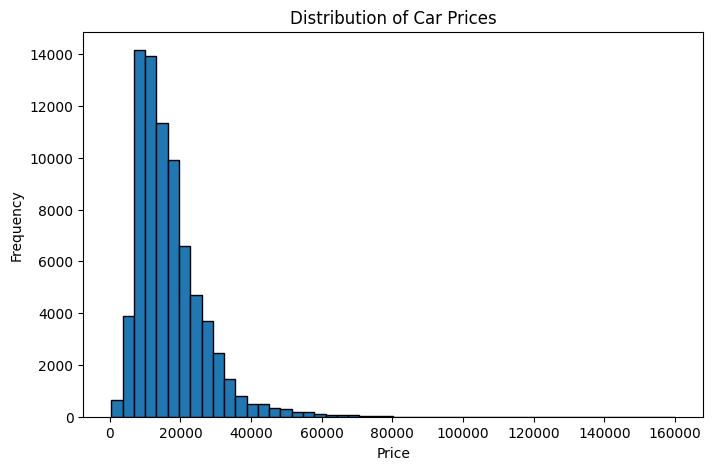

In [46]:
plt.figure(figsize=(8, 5))
plt.hist(df["price"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [47]:
df["price"].describe()

,price
count,75973.000000
mean,16881.889553
std,9736.926322
min,450.000000
25%,10200.000000
50%,14699.000000
75%,20950.000000
max,159999.000000


In [48]:
ordenado = df.sort_values("price", ascending=True)

baratos = ordenado[["Brand", "model", "year", "price"]].head(5)
caros = baratos[["Brand", "model", "year", "price"]].tail(5)
display(baratos)
display(caros)
#acho possível estes carros em especifico terem estes preços

,Brand,model,year,price
carID,,,,
60156,Opel,AGILA,2003.0,450
19562,Ford,FOCUS,2003.0,495
23427,Ford,FOCUS,2003.0,495
61005,Opel,CORSA,2002.0,495
55950,Opel,CORSA,2003.0,590


,Brand,model,year,price
carID,,,,
60156,Opel,AGILA,2003.0,450
19562,Ford,FOCUS,2003.0,495
23427,Ford,FOCUS,2003.0,495
61005,Opel,CORSA,2002.0,495
55950,Opel,CORSA,2003.0,590


In [49]:
def preco_no_fim(df):
    df = df.copy()

    df = df[[col for col in df.columns if col != "price"] + ["price"]]
    return df

## **3.2 Year analysis and cleaning**

In [50]:
df["year"].unique()

array([2016.        , 2019.        , 2018.        , 2014.        ,
       2017.        , 2020.        , 2013.        ,           nan,
       2015.        , 2023.36707842, 2011.        , 2012.        ,
       2023.1169636 , 2003.        , 2009.        , 2007.        ,
       2005.        , 2011.11118842, 2011.21085349, 2023.97731126,
       2004.        , 2010.        , 2010.56500919, 2008.        ,
       2024.12175905, 2006.        , 2023.60527574, 2023.38982198,
       2010.67696784, 2001.        , 2000.        , 2023.26798867,
       2010.26863473, 2010.37154646, 2002.        , 2022.69668507,
       2009.81675711, 2010.7464032 , 2012.69574039, 1996.        ,
       1998.        , 2022.87800554, 1970.        , 1999.        ,
       1997.        ])

In [51]:
df[df["year"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
35263,Mercedes,CCLASS,NaN,11295,AUTOMATIC,45000.0,PETROL,-56.193202,46.3,1.6,59.0,NaN,0.0
68423,VW,POLO,NaN,10328,NaN,26941.0,PETROL,145.000000,60.1,1.2,97.0,4.0,0.0
49731,Skoda,OCTAVIA,NaN,11990,MANUAL,35650.0,NaN,30.000000,55.4,1.4,68.0,3.0,0.0
38604,Mercedes,ECLASS,NaN,34980,SEMI-AUTO,4196.0,DIESEL,145.000000,70.6,2.0,44.0,1.0,0.0
37812,Mercedes,ECLASS,NaN,17165,AUTOMATIC,36959.0,DIESEL,150.000000,53.3,3.0,53.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67270,VW,POLO,NaN,6880,SEMI-AUTO,44551.0,PETROL,145.000000,47.9,1.4,92.0,2.0,0.0
61087,Opel,Unknown,NaN,14295,MANUAL,14609.0,PETROL,145.000000,39.2,1.4,50.0,2.0,0.0
62592,Opel,ASTRA,NaN,10295,MANUAL,10271.0,PETROL,145.000000,62.8,1.0,99.0,3.0,0.0


In [52]:
old_cars = df[df["year"] < 2000][["Brand", "model", "year"]]
display(old_cars)
#os carros de 1970 nem existiam em 1970

,Brand,model,year
carID,,,
25881,Ford,ESCORT,1996.0
3908,Audi,A3,1998.0
62732,Opel,ZAFIRA,1970.0
13422,BMW,Z3,1999.0
36128,Mercedes,SLK,1998.0
51800,Toyota,YARIS,1999.0
34918,Mercedes,SCLASS,1997.0
52914,Toyota,LANDCRUISER,1998.0
35769,Mercedes,MCLASS,1970.0


In [53]:
def limpar_anos(df):
    df = df.copy()

    df["year"] = np.round(df["year"]).astype("float")
    df.loc[(df["year"] < 1980) | (df["year"] > 2020),"year"] = np.nan
    df["year"] = df["year"].astype("Int64")
    return df

In [54]:
df = limpar_anos(df) # call the function "limpar_anos(df)"
df[df["year"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
35263,Mercedes,CCLASS,<NA>,11295,AUTOMATIC,45000.0,PETROL,-56.193202,46.3,1.6,59.0,NaN,0.0
53282,Toyota,YARIS,<NA>,16995,MANUAL,1225.0,PETROL,145.000000,47.9,1.5,77.0,0.0,0.0
68423,VW,POLO,<NA>,10328,NaN,26941.0,PETROL,145.000000,60.1,1.2,97.0,4.0,0.0
49731,Skoda,OCTAVIA,<NA>,11990,MANUAL,35650.0,NaN,30.000000,55.4,1.4,68.0,3.0,0.0
38604,Mercedes,ECLASS,<NA>,34980,SEMI-AUTO,4196.0,DIESEL,145.000000,70.6,2.0,44.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67270,VW,POLO,<NA>,6880,SEMI-AUTO,44551.0,PETROL,145.000000,47.9,1.4,92.0,2.0,0.0
61087,Opel,Unknown,<NA>,14295,MANUAL,14609.0,PETROL,145.000000,39.2,1.4,50.0,2.0,0.0
62592,Opel,ASTRA,<NA>,10295,MANUAL,10271.0,PETROL,145.000000,62.8,1.0,99.0,3.0,0.0


In [55]:
df["year"].unique()

<IntegerArray>
[2016, 2019, 2018, 2014, 2017, 2020, 2013, <NA>, 2015, 2011, 2012, 2003, 2009,
 2007, 2005, 2004, 2010, 2008, 2006, 2001, 2000, 2002, 1996, 1998, 1999, 1997]
Length: 26, dtype: Int64

In [56]:
sorted(df["year"].dropna().unique())


[np.int64(1996),
 np.int64(1997),
 np.int64(1998),
 np.int64(1999),
 np.int64(2000),
 np.int64(2001),
 np.int64(2002),
 np.int64(2003),
 np.int64(2004),
 np.int64(2005),
 np.int64(2006),
 np.int64(2007),
 np.int64(2008),
 np.int64(2009),
 np.int64(2010),
 np.int64(2011),
 np.int64(2012),
 np.int64(2013),
 np.int64(2014),
 np.int64(2015),
 np.int64(2016),
 np.int64(2017),
 np.int64(2018),
 np.int64(2019),
 np.int64(2020)]

## **3.3 Mileage analysis and cleaning**

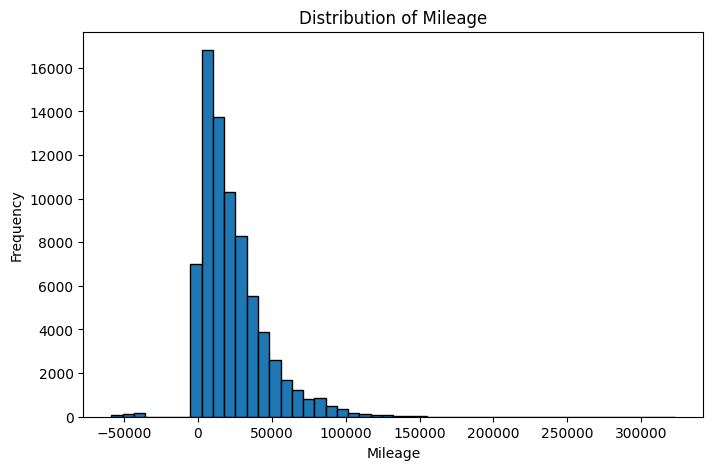

In [57]:
plt.figure(figsize=(8, 5))
plt.hist(df["mileage"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of Mileage")
plt.xlabel("Mileage")
plt.ylabel("Frequency")
plt.show()

In [58]:
df[df["mileage"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
64396,Opel,ASTRA,2015,6995,NaN,NaN,DIESEL,0.000000,78.5,1.6,61.0,2.0,0.0
41441,Mercedes,ACLASS,2017,13500,MANUAL,NaN,DIESEL,150.000000,72.4,1.5,32.0,2.0,0.0
22269,Ford,FIESTA,2017,8930,NaN,NaN,PETROL,145.000000,54.3,1.2,97.0,0.0,0.0
6409,Audi,A1,2016,10999,MANUAL,NaN,DIESEL,0.000000,76.3,1.6,97.0,3.0,0.0
7725,BMW,X2,2019,23633,MANUAL,NaN,DIESEL,145.000000,53.3,2.0,97.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33828,Hyundai,TUCSON,2019,18390,MANUAL,NaN,PETROL,145.000000,34.9,1.6,86.0,4.0,0.0
55680,Toyota,CHR,2017,20700,AUTOMATIC,NaN,HYBRID,135.000000,74.3,1.8,86.0,0.0,0.0
39353,Mercedes,GLCLASS,2019,36490,SEMI-AUTO,NaN,DIESEL,145.000000,40.9,2.0,36.0,3.0,0.0


In [59]:
df[df["mileage"] < 0]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
70615,VW,TIGUAN,2020,25000,MANUAL,-48190.655673,PETROL,145.0,38.2,1.5,89.0,3.0,0.0
43529,Mercedes,CCLASS,2019,25780,SEMI-AUTO,-50755.210230,DIESEL,NaN,NaN,2.0,72.0,3.0,0.0
71090,VW,GOLF,2018,14995,MANUAL,-48190.655673,DIESEL,150.0,57.7,1.6,83.0,2.0,0.0
7845,BMW,3SERIES,2019,23498,SEMI-AUTO,-58540.574478,DIESEL,145.0,54.3,2.0,38.0,NaN,0.0
24999,Ford,FIESTA,2017,8895,MANUAL,-42650.453719,PETROL,125.0,54.3,1.2,45.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56373,Opel,Unknown,2018,8514,MANUAL,-42707.564215,PETROL,150.0,55.4,1.4,49.0,1.0,NaN
45765,Mercedes,GLCLASS,2020,54995,AUTOMATIC,-50755.210230,DIESEL,150.0,32.8,3.0,69.0,4.0,0.0
38413,Mercedes,SLK,2015,17900,AUTOMATIC,-50755.210230,DIESEL,150.0,56.5,2.1,40.0,3.0,0.0


In [60]:
def impossible_to_nan(df, col, val=0, lower_upper="lower"):
    # Make a copy of the original DataFrame so the original data isn't modified directly
    df = df.copy()

    # Check whether we want to filter out values lower than 'val' or greater than 'val'
    if lower_upper == "lower":
        # If 'lower', replace all values in 'col' that are smaller than 'val' with NaN
        df.loc[df[col] < val, col] = np.nan
        # Return the cleaned DataFrame
        return df
    else:
        # If 'upper', replace all values in 'col' that are greater than 'val' with NaN
        df.loc[df[col] > val, col] = np.nan
        # Return the cleaned DataFrame
        return df


In [61]:
df = impossible_to_nan(df, "mileage")

if USE_TOY:
    # Em toy dataset a última linha é 999
    print("\nTOY MODE → mostrando última linha para inspecção:")
    display(df.loc[df.index.max()])
else:
    print("\nFULL MODE → mostrando linha 70615 para inspecção:")
    display(df.loc[70615])



FULL MODE → mostrando linha 70615 para inspecção:


,70615
Brand,VW
model,TIGUAN
year,2020
price,25000
transmission,MANUAL
mileage,NaN
fuelType,PETROL
tax,145.0
mpg,38.2
engineSize,1.5


In [62]:
df[df["mileage"] < 0]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,


In [63]:
df[df["mileage"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
64396,Opel,ASTRA,2015,6995,NaN,NaN,DIESEL,0.000000,78.5,1.6,61.0,2.0,0.0
41441,Mercedes,ACLASS,2017,13500,MANUAL,NaN,DIESEL,150.000000,72.4,1.5,32.0,2.0,0.0
22269,Ford,FIESTA,2017,8930,NaN,NaN,PETROL,145.000000,54.3,1.2,97.0,0.0,0.0
6409,Audi,A1,2016,10999,MANUAL,NaN,DIESEL,0.000000,76.3,1.6,97.0,3.0,0.0
7725,BMW,X2,2019,23633,MANUAL,NaN,DIESEL,145.000000,53.3,2.0,97.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39353,Mercedes,GLCLASS,2019,36490,SEMI-AUTO,NaN,DIESEL,145.000000,40.9,2.0,36.0,3.0,0.0
9474,BMW,3SERIES,2016,14000,MANUAL,NaN,DIESEL,316.487189,62.8,2.0,77.0,4.0,0.0
55820,Toyota,AYGO,2019,8491,MANUAL,NaN,PETROL,145.000000,56.5,1.0,56.0,0.0,0.0


## **3.4 Tax analysis**

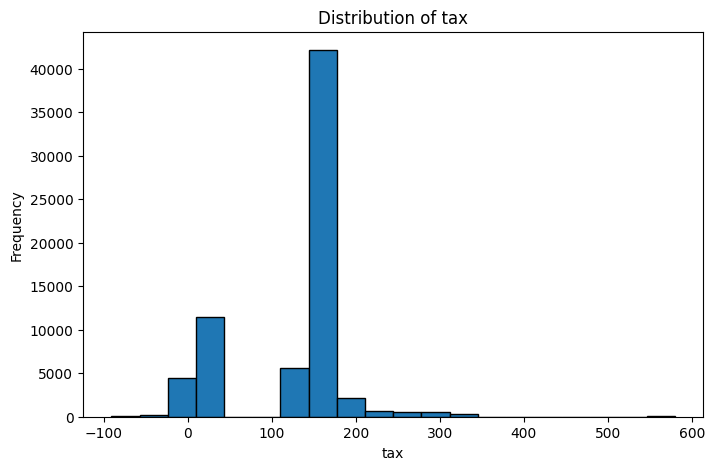

In [64]:
plt.figure(figsize=(8, 5))
plt.hist(df["tax"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of tax")
plt.xlabel("tax")
plt.ylabel("Frequency")
plt.show()

In [65]:
df[df["tax"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,GOLF,2016,22290,SEMI-AUTO,28421.0,PETROL,NaN,11.417268,2.0,63.0,4.0,0.0
20142,Ford,FOCUS,2017,18997,MANUAL,20112.0,PETROL,NaN,NaN,2.0,40.0,4.0,0.0
39796,Mercedes,CCLASS,2019,31299,SEMI-AUTO,1000.0,DIESEL,NaN,NaN,2.0,33.0,4.0,0.0
35317,Mercedes,CCLASS,2019,26176,NaN,9463.0,PETROL,NaN,NaN,1.5,87.0,1.0,0.0
35004,Mercedes,CCLASS,2016,21499,AUTOMATIC,26741.0,DIESEL,NaN,NaN,2.1,80.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24300,Ford,FOCUS,2017,17000,MANUAL,26041.0,DIESEL,NaN,NaN,2.0,39.0,3.0,0.0
40757,Mercedes,CCLASS,2019,28980,AUTOMATIC,8501.0,DIESEL,NaN,NaN,2.0,97.0,3.0,0.0
19457,Ford,FOCUS,2019,18910,MANUAL,11167.0,PETROL,NaN,NaN,1.0,30.0,4.0,0.0


In [66]:
def impossible_to_nan(df, col, val=0, lower_upper="lower"):
    df=df.copy()

    if lower_upper=="lower":
        df.loc[df[col]<val, col] = np.nan
        return df
    else:
        df.loc[df[col]>val, col] = np.nan
        return df

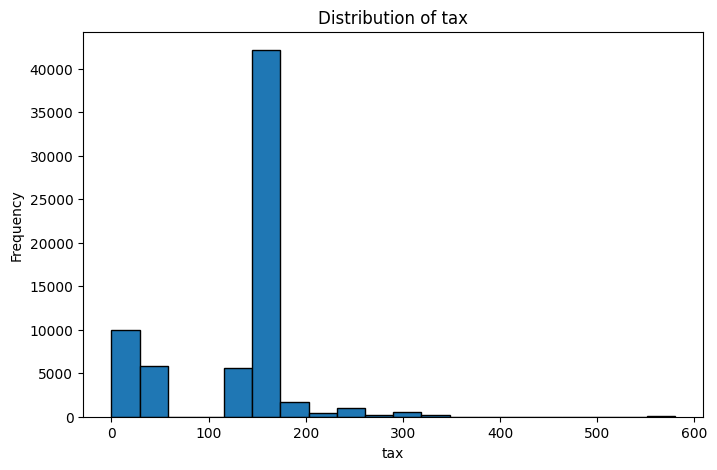

In [67]:
df=impossible_to_nan(df, "tax")

plt.figure(figsize=(8, 5))
plt.hist(df["tax"].dropna(), bins=20, edgecolor="black")
plt.title("Distribution of tax")
plt.xlabel("tax")
plt.ylabel("Frequency")
plt.show()

In [68]:
df[df["tax"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
69512,VW,GOLF,2016,22290,SEMI-AUTO,28421.0,PETROL,NaN,11.417268,2.0,63.0,4.0,0.0
20142,Ford,FOCUS,2017,18997,MANUAL,20112.0,PETROL,NaN,NaN,2.0,40.0,4.0,0.0
39796,Mercedes,CCLASS,2019,31299,SEMI-AUTO,1000.0,DIESEL,NaN,NaN,2.0,33.0,4.0,0.0
35317,Mercedes,CCLASS,2019,26176,NaN,9463.0,PETROL,NaN,NaN,1.5,87.0,1.0,0.0
35263,Mercedes,CCLASS,<NA>,11295,AUTOMATIC,45000.0,PETROL,NaN,46.300000,1.6,59.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24300,Ford,FOCUS,2017,17000,MANUAL,26041.0,DIESEL,NaN,NaN,2.0,39.0,3.0,0.0
40757,Mercedes,CCLASS,2019,28980,AUTOMATIC,8501.0,DIESEL,NaN,NaN,2.0,97.0,3.0,0.0
19457,Ford,FOCUS,2019,18910,MANUAL,11167.0,PETROL,NaN,NaN,1.0,30.0,4.0,0.0


In [69]:
g = df[df["tax"] == 0]
g["year"].value_counts()

,count
year,
2016,1675
2017,1046
2015,827
2014,391
2013,221
2012,26
2011,16
2010,15
2009,5


## **3.5 mpg analysis**

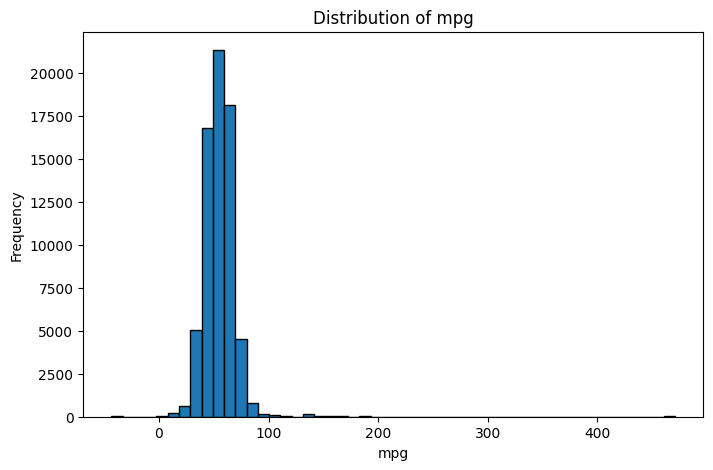

In [70]:
plt.figure(figsize=(8, 5))
plt.hist(df["mpg"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of mpg")
plt.xlabel("mpg")
plt.ylabel("Frequency")
plt.show()
#FIXE

In [71]:
df[df["mpg"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
20142,Ford,FOCUS,2017,18997,MANUAL,20112.0,PETROL,NaN,NaN,2.0,40.0,4.0,0.0
39796,Mercedes,CCLASS,2019,31299,SEMI-AUTO,1000.0,DIESEL,NaN,NaN,2.0,33.0,4.0,0.0
35317,Mercedes,CCLASS,2019,26176,NaN,9463.0,PETROL,NaN,NaN,1.5,87.0,1.0,0.0
35004,Mercedes,CCLASS,2016,21499,AUTOMATIC,26741.0,DIESEL,NaN,NaN,2.1,80.0,1.0,0.0
19811,Ford,FOCUS,2019,17990,AUTOMATIC,3289.0,DIESEL,NaN,NaN,1.5,38.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24300,Ford,FOCUS,2017,17000,MANUAL,26041.0,DIESEL,NaN,NaN,2.0,39.0,3.0,0.0
1016,Audi,Q5,2016,22995,NaN,28000.0,DIESEL,200.0,NaN,2.0,42.0,4.0,0.0
40757,Mercedes,CCLASS,2019,28980,AUTOMATIC,8501.0,DIESEL,NaN,NaN,2.0,97.0,3.0,0.0


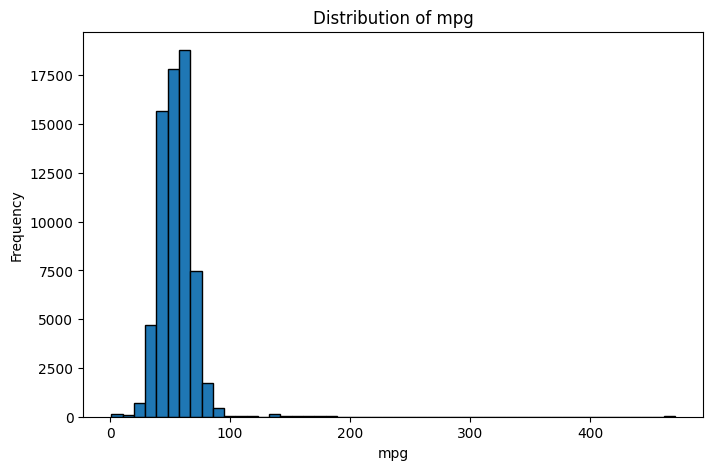

In [72]:
df=impossible_to_nan(df, "mpg")

plt.figure(figsize=(8, 5))
plt.hist(df["mpg"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of mpg")
plt.xlabel("mpg")
plt.ylabel("Frequency")
plt.show()

In [73]:
df[df["mpg"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
20142,Ford,FOCUS,2017,18997,MANUAL,20112.0,PETROL,NaN,NaN,2.0,40.0,4.0,0.0
39796,Mercedes,CCLASS,2019,31299,SEMI-AUTO,1000.0,DIESEL,NaN,NaN,2.0,33.0,4.0,0.0
35317,Mercedes,CCLASS,2019,26176,NaN,9463.0,PETROL,NaN,NaN,1.5,87.0,1.0,0.0
35004,Mercedes,CCLASS,2016,21499,AUTOMATIC,26741.0,DIESEL,NaN,NaN,2.1,80.0,1.0,0.0
19811,Ford,FOCUS,2019,17990,AUTOMATIC,3289.0,DIESEL,NaN,NaN,1.5,38.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24300,Ford,FOCUS,2017,17000,MANUAL,26041.0,DIESEL,NaN,NaN,2.0,39.0,3.0,0.0
1016,Audi,Q5,2016,22995,NaN,28000.0,DIESEL,200.0,NaN,2.0,42.0,4.0,0.0
40757,Mercedes,CCLASS,2019,28980,AUTOMATIC,8501.0,DIESEL,NaN,NaN,2.0,97.0,3.0,0.0


## **3.5 Engine size analysis**

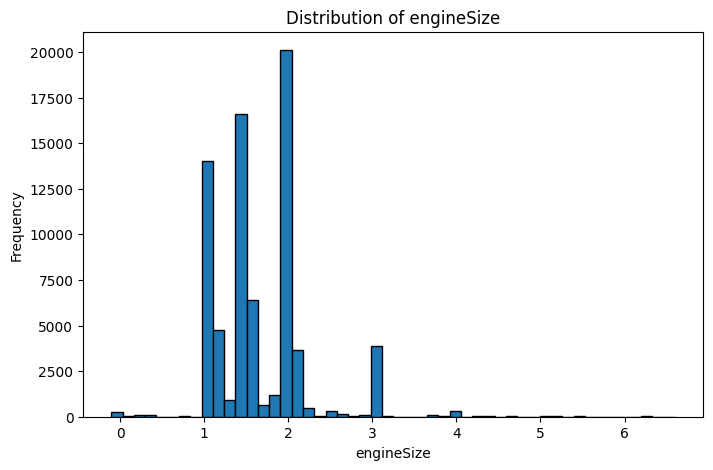

In [74]:
plt.figure(figsize=(8, 5))
plt.hist(df["engineSize"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of engineSize")
plt.xlabel("engineSize")
plt.ylabel("Frequency")
plt.show()

In [75]:
df[df["engineSize"] < 0.6]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
30317,Ford,Unknown,2019,9999,MANUAL,10000.0,PETROL,145.0,47.9,0.000000,61.0,3.0,0.0
24113,Ford,KUGA,<NA>,14950,MANUAL,13411.0,DIESEL,125.0,60.1,-0.103493,83.0,1.0,0.0
3840,Audi,Unknown,2019,21262,MANUAL,4868.0,DIESEL,145.0,49.6,0.154529,58.0,2.0,0.0
21935,Ford,KA,2018,8444,MANUAL,17000.0,PETROL,145.0,57.7,0.000000,51.0,0.0,0.0
9518,BMW,2SERIES,2015,14700,AUTOMATIC,32882.0,DIESEL,125.0,60.1,0.000000,55.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33307,Hyundai,I10,2018,8500,MANUAL,12948.0,PETROL,145.0,60.1,0.000000,46.0,2.0,0.0
46732,Skoda,OCTAVIA,2018,11290,MANUAL,20047.0,PETROL,145.0,58.9,0.191462,98.0,0.0,0.0
38494,Mercedes,GLCLASS,2016,19498,SEMI-AUTO,27846.0,DIESEL,125.0,56.5,0.307074,89.0,4.0,0.0


In [76]:
df[df["engineSize"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
48622,Skoda,FABIA,2019,13295,AUTOMATIC,14378.0,PETROL,145.0,60.1,NaN,59.0,1.0,0.0
38898,Mercedes,GLCLASS,2017,28995,AUTOMATIC,30808.0,DIESEL,150.0,56.5,NaN,60.0,1.0,0.0
54844,Toyota,AYGO,2017,7299,MANUAL,48238.0,PETROL,0.0,68.9,NaN,80.0,0.0,0.0
57086,Opel,INSIGNIA,2017,7695,MANUAL,51840.0,DIESEL,0.0,74.3,NaN,76.0,2.0,0.0
70418,VW,GOLF,2016,16898,MANUAL,24180.0,DIESEL,20.0,67.3,NaN,83.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68840,VW,POLO,2019,14999,MANUAL,4436.0,PETROL,150.0,52.3,NaN,98.0,2.0,0.0
61373,Opel,ASTRA,2017,10800,MANUAL,19025.0,PETROL,125.0,50.4,NaN,36.0,0.0,0.0
68148,VW,GOLF,2020,20769,MANUAL,1116.0,PETROL,145.0,49.6,NaN,86.0,4.0,0.0


In [77]:
df=impossible_to_nan(df, "engineSize", 0.49)
df[df["engineSize"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
48622,Skoda,FABIA,2019,13295,AUTOMATIC,14378.0,PETROL,145.0,60.1,NaN,59.0,1.0,0.0
38898,Mercedes,GLCLASS,2017,28995,AUTOMATIC,30808.0,DIESEL,150.0,56.5,NaN,60.0,1.0,0.0
30317,Ford,Unknown,2019,9999,MANUAL,10000.0,PETROL,145.0,47.9,NaN,61.0,3.0,0.0
54844,Toyota,AYGO,2017,7299,MANUAL,48238.0,PETROL,0.0,68.9,NaN,80.0,0.0,0.0
57086,Opel,INSIGNIA,2017,7695,MANUAL,51840.0,DIESEL,0.0,74.3,NaN,76.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70592,VW,CADDYMAXI,2015,9995,SEMI-AUTO,66000.0,DIESEL,200.0,48.7,NaN,34.0,3.0,0.0
68148,VW,GOLF,2020,20769,MANUAL,1116.0,PETROL,145.0,49.6,NaN,86.0,4.0,0.0
10627,BMW,3SERIES,2020,24990,SEMI-AUTO,22.0,DIESEL,150.0,54.3,NaN,90.0,1.0,0.0


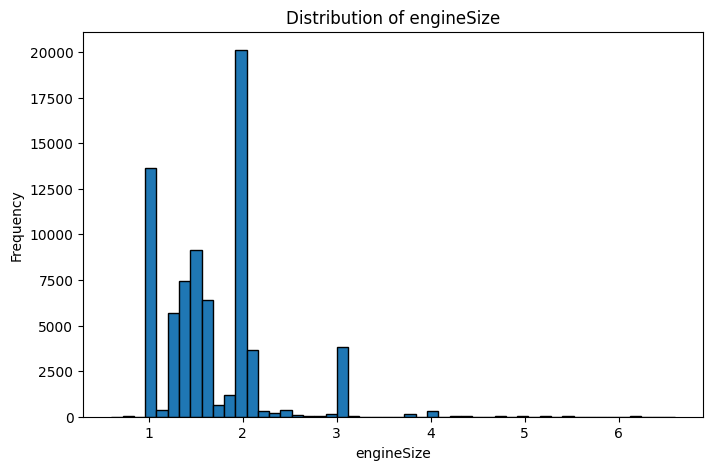

In [78]:
plt.figure(figsize=(8, 5))
plt.hist(df["engineSize"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of engineSize")
plt.xlabel("engineSize")
plt.ylabel("Frequency")
plt.show()

## **3.6 paintQuality analysis**

In [79]:
df["paintQuality%"].describe()

,paintQuality%
count,74449.000000
mean,64.590667
std,21.021065
min,1.638913
25%,47.000000
50%,65.000000
75%,82.000000
max,125.594308


In [80]:
df[df["paintQuality%"] > 100]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
15717,Ford,FIESTA,2018,10491,MANUAL,6522.0,PETROL,145.0,65.7,1.0,125.109951,3.0,0.0
11200,BMW,4SERIES,2019,23591,SEMI-AUTO,6100.0,PETROL,145.0,45.6,2.0,125.569499,2.0,0.0
53403,Toyota,AYGO,2016,7995,MANUAL,25300.0,NaN,0.0,69.0,1.0,125.594308,1.0,0.0
48038,Skoda,YETIOUTDOOR,2015,11995,SEMI-AUTO,19805.0,PETROL,125.0,51.4,1.2,125.453599,1.0,0.0
10137,BMW,5SERIES,2017,21995,AUTOMATIC,18820.0,DIESEL,145.0,65.7,2.0,125.569499,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75768,VW,TIGUAN,2018,18499,MANUAL,24940.0,PETROL,145.0,48.7,1.4,125.366507,0.0,0.0
39666,Mercedes,ECLASS,2017,21602,SEMI-AUTO,40690.0,DIESEL,145.0,NaN,3.0,125.202033,3.0,0.0
23930,Ford,FIESTA,2020,15000,MANUAL,35.0,PETROL,145.0,56.5,1.0,125.109951,0.0,0.0


In [81]:
df[df["paintQuality%"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
47148,Skoda,RAPID,2016,7991,MANUAL,33395.0,DIESEL,0.0,67.3,1.6,NaN,3.0,0.0
25484,Ford,BMAX,2016,9498,MANUAL,14853.0,DIESEL,0.0,74.4,1.5,NaN,1.0,0.0
41801,Mercedes,CCLASS,2019,49499,SEMI-AUTO,1000.0,PETROL,145.0,29.1,3.0,NaN,2.0,0.0
55579,Toyota,YARIS,2019,11280,MANUAL,6065.0,PETROL,145.0,47.9,1.5,NaN,0.0,0.0
55572,Toyota,AYGO,2019,10195,MANUAL,2114.0,PETROL,145.0,57.7,1.0,NaN,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26105,Ford,FOCUS,2013,6698,SEMI-AUTO,32685.0,PETROL,160.0,44.1,1.6,NaN,0.0,0.0
62623,Opel,MOKKAX,2019,14995,MANUAL,10.0,PETROL,145.0,39.2,1.4,NaN,0.0,NaN
64505,Opel,CORSA,2016,6999,MANUAL,13046.0,PETROL,30.0,55.4,1.4,NaN,0.0,0.0


In [82]:
df = impossible_to_nan(df,"paintQuality%", 100, "upper")
df[df["paintQuality%"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
47148,Skoda,RAPID,2016,7991,MANUAL,33395.0,DIESEL,0.0,67.3,1.6,NaN,3.0,0.0
25484,Ford,BMAX,2016,9498,MANUAL,14853.0,DIESEL,0.0,74.4,1.5,NaN,1.0,0.0
41801,Mercedes,CCLASS,2019,49499,SEMI-AUTO,1000.0,PETROL,145.0,29.1,3.0,NaN,2.0,0.0
55579,Toyota,YARIS,2019,11280,MANUAL,6065.0,PETROL,145.0,47.9,1.5,NaN,0.0,0.0
55572,Toyota,AYGO,2019,10195,MANUAL,2114.0,PETROL,145.0,57.7,1.0,NaN,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26105,Ford,FOCUS,2013,6698,SEMI-AUTO,32685.0,PETROL,160.0,44.1,1.6,NaN,0.0,0.0
62623,Opel,MOKKAX,2019,14995,MANUAL,10.0,PETROL,145.0,39.2,1.4,NaN,0.0,NaN
64505,Opel,CORSA,2016,6999,MANUAL,13046.0,PETROL,30.0,55.4,1.4,NaN,0.0,0.0


In [83]:
df["paintQuality%"].describe()

,paintQuality%
count,74082.000000
mean,64.290118
std,20.633703
min,1.638913
25%,47.000000
50%,64.000000
75%,82.000000
max,99.000000


## **3.7 previous Owners analysis**

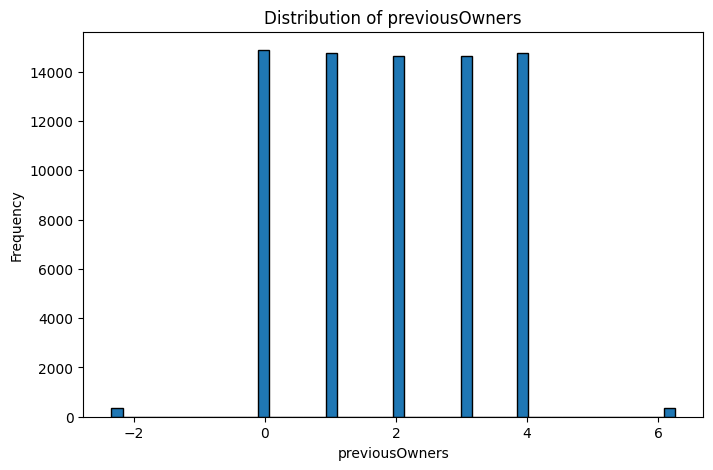

In [84]:
plt.figure(figsize=(8, 5))
plt.hist(df["previousOwners"].dropna(), bins=50, edgecolor="black")
plt.title("Distribution of previousOwners")
plt.xlabel("previousOwners")
plt.ylabel("Frequency")
plt.show()

In [85]:
df["previousOwners"].unique()

array([ 4.        ,  1.        , -2.34030622,  3.        ,  0.        ,
        2.        ,         nan, -2.34565   ,  6.25837066, -2.33512284,
        6.22789796,  6.25823052,  6.23017958, -2.33936045,  6.21772443,
        6.24583495, -2.29943868, -2.34010209, -2.31225953,  6.2482512 ,
       -2.31733109,  6.23308217,  6.24177863, -2.33744529])

In [86]:
df[df["previousOwners"]<0]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
29021,Ford,FIESTA,2018,12500,MANUAL,9102.0,PETROL,145.0,65.7,1.0,50.0,-2.340306,0.0
71677,VW,TIGUAN,2019,29999,SEMI-AUTO,669.0,DIESEL,145.0,39.8,2.0,42.0,-2.345650,0.0
16962,Ford,FOCUS,2019,19950,AUTOMATIC,7142.0,DIESEL,NaN,NaN,2.0,41.0,-2.340306,0.0
5994,Audi,Unknown,2020,31990,SEMI-AUTO,4432.0,PETROL,150.0,40.4,1.5,98.0,-2.335123,0.0
5038,Audi,RS6,2020,97500,SEMI-AUTO,3220.0,PETROL,150.0,22.1,4.0,72.0,-2.335123,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67526,VW,PASSAT,2020,20998,SEMI-AUTO,15.0,DIESEL,145.0,49.6,1.6,62.0,-2.345650,0.0
75599,VW,UP,2015,6795,MANUAL,10800.0,PETROL,20.0,61.4,1.0,31.0,-2.345650,0.0
28295,Ford,SMAX,2017,17950,MANUAL,28280.0,PETROL,145.0,43.5,1.5,45.0,-2.340306,0.0


In [87]:
df[df["previousOwners"].isna()]

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
carID,,,,,,,,,,,,,
35263,Mercedes,CCLASS,<NA>,11295,AUTOMATIC,45000.0,PETROL,NaN,46.3,1.6,59.0,NaN,0.0
18304,Ford,Unknown,2016,9632,MANUAL,18814.0,PETROL,20.0,62.8,1.0,74.0,NaN,0.0
49135,Skoda,SCALA,2020,17000,MANUAL,731.0,PETROL,150.0,50.4,1.0,88.0,NaN,0.0
37446,Mercedes,CCLASS,2019,27099,SEMI-AUTO,1059.0,PETROL,145.0,45.6,1.5,87.0,NaN,0.0
1768,Audi,Q3,2020,35990,SEMI-AUTO,6000.0,DIESEL,145.0,47.1,2.0,48.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,Audi,A7,2014,19499,AUTOMATIC,47317.0,DIESEL,145.0,54.3,3.0,57.0,NaN,0.0
6295,Audi,A3,2018,17650,MANUAL,6350.0,PETROL,150.0,55.4,1.5,60.0,NaN,0.0
21918,Ford,FIESTA,2019,13998,MANUAL,10576.0,PETROL,145.0,58.9,1.0,65.0,NaN,0.0


In [88]:
def round_owners_int(df):
    df=df.copy()
    df["previousOwners"] = pd.to_numeric(df["previousOwners"], errors="coerce")

    df['previousOwners'] = df['previousOwners'].round().astype('Int64')
    return df

In [89]:
df=impossible_to_nan(df,"previousOwners")
df=round_owners_int(df)
df["previousOwners"].unique()

<IntegerArray>
[4, 1, <NA>, 3, 0, 2, 6]
Length: 7, dtype: Int64

## **3.8 hasDamage analysis**

In [90]:
df["hasDamage"].unique() #está cheia de zeros

array([ 0., nan])

In [91]:
def remove_hasdmg(df):
    df = df.copy()

    df = df.drop(columns=['hasDamage'])
    return df

In [92]:
df=remove_hasdmg(df)

In [93]:
display(df)

,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,,
69512,VW,GOLF,2016,22290,SEMI-AUTO,28421.0,PETROL,NaN,11.417268,2.0,63.0,4
53000,Toyota,YARIS,2019,13790,MANUAL,4589.0,PETROL,145.0,47.900000,1.5,50.0,1
6366,Audi,Q2,2019,24990,SEMI-AUTO,3624.0,PETROL,145.0,40.900000,1.5,56.0,4
29021,Ford,FIESTA,2018,12500,MANUAL,9102.0,PETROL,145.0,65.700000,1.0,50.0,<NA>
10062,BMW,2SERIES,2019,22995,MANUAL,1000.0,PETROL,145.0,42.800000,1.5,97.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
37194,Mercedes,CCLASS,2015,13498,MANUAL,14480.0,PETROL,125.0,53.300000,2.0,78.0,0
6265,Audi,Q3,2013,12495,SEMI-AUTO,52134.0,DIESEL,200.0,47.900000,2.0,38.0,2
54886,Toyota,AYGO,2017,8399,AUTOMATIC,11304.0,PETROL,145.0,67.000000,1.0,57.0,3


# **4. MIssing Values exploration**

## **4.1 Missing Values Overview (EDA)**


In [94]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing Percentage': (missing / len(df)) * 100
})

print("Missing Values with Percentage:\n")
print(missing_df)



Missing Values with Percentage:

                Missing Count  Missing Percentage
tax                      8282           10.901241
mpg                      7962           10.480039
engineSize               2034            2.677267
previousOwners           1921            2.528530
paintQuality%            1891            2.489042
year                     1851            2.436392
mileage                  1832            2.411383
transmission             1522            2.003343
fuelType                 1511            1.988864
Brand                     104            0.136891


## **4.2 Missing Data Handling Strategy**

In [95]:
"""
Missing Data Handling Strategy

- Categorical variables: fill missing values with 'Unknown'
- Numerical variables: invalid or impossible values are converted to NaN
  (handled later during imputation in the ML pipeline)
- Cleaning functions are applied consistently across all datasets
"""


"\nMissing Data Handling Strategy\n\n- Categorical variables: fill missing values with 'Unknown'\n- Numerical variables: invalid or impossible values are converted to NaN\n  (handled later during imputation in the ML pipeline)\n- Cleaning functions are applied consistently across all datasets\n"

## **4.3 Helper Functions for Missing Values**

In [96]:
def fill_cats_UNKNOWN(df, cats):
    df = df.copy()
    for column in cats:
        df[column] = df[column].fillna('Unknown')

    return df

## **4.4 Feature Grouping**

In [97]:
num_cols = ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']
cat_cols = ['Brand', 'model', 'transmission', 'fuelType']
int_cols = ['year', 'previousOwners']
float_cols = ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%']

## **4.5 Full Data Cleaning Pipeline**

In [98]:
def clean_df(df, valid_models):
    df=df.copy()

    df=carID_como_index(df)
    df=fuzzy_marcas(df)
    df=fuzzy_modelos(df, valid_models)
    df=inferir_marca_com_modelo(df, valid_models)
    df=limpar_anos(df)
    df=fuzzy_transmissao(df)
    df=impossible_to_nan(df, "mileage")
    df=fuzzy_fuel(df)
    df=impossible_to_nan(df, "tax")
    df=impossible_to_nan(df, "mpg")
    df=impossible_to_nan(df, "engineSize", 0.49)
    df=impossible_to_nan(df,"paintQuality%", 100, "upper")
    df=impossible_to_nan(df,"previousOwners")
    df=round_owners_int(df)
    df=remove_hasdmg(df)
    df=fill_cats_UNKNOWN(df,cat_cols)

    return df

## **4.6 Data Cleaning Execution & Validation**


In [99]:
df=fill_cats_UNKNOWN(df, cat_cols)

In [100]:
og_df=clean_df(og_df, valid_models)

In [101]:
assert pd.testing.assert_frame_equal(df, og_df) is None

# **5. DATA SPLIT & PREPROCESSING PIPELINE**



### Pipeline Strategy

This preprocessing pipeline was designed to strictly prevent data leakage and
to mirror a real-world deployment scenario. All statistics required for data
transformation (imputation values, outlier thresholds, scaling parameters) are
learned exclusively from the training set and then reused unchanged on the
validation data.

The pipeline follows a clear and reproducible order:
1. Feature–target separation
2. Train–validation split
3. Training-based preprocessing (imputation, outlier handling, scaling)
4. Consistent application of learned transformations to unseen data

This approach ensures fair model evaluation and reliable generalisation
performance.

All exploratory plots are generated exclusively from the training set to avoid
any influence from unseen validation data.



## **5.1 Feature–Target Separation**

In [102]:
def separar_y(df):
    df=df.copy()

    X = df.drop('price', axis = 1)
    y = df['price']

    return X, y

In [103]:
X, y = separar_y(df)
X

,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,,,,,
69512,VW,GOLF,2016,SEMI-AUTO,28421.0,PETROL,NaN,11.417268,2.0,63.0,4
53000,Toyota,YARIS,2019,MANUAL,4589.0,PETROL,145.0,47.900000,1.5,50.0,1
6366,Audi,Q2,2019,SEMI-AUTO,3624.0,PETROL,145.0,40.900000,1.5,56.0,4
29021,Ford,FIESTA,2018,MANUAL,9102.0,PETROL,145.0,65.700000,1.0,50.0,<NA>
10062,BMW,2SERIES,2019,MANUAL,1000.0,PETROL,145.0,42.800000,1.5,97.0,3
...,...,...,...,...,...,...,...,...,...,...,...
37194,Mercedes,CCLASS,2015,MANUAL,14480.0,PETROL,125.0,53.300000,2.0,78.0,0
6265,Audi,Q3,2013,SEMI-AUTO,52134.0,DIESEL,200.0,47.900000,2.0,38.0,2
54886,Toyota,AYGO,2017,AUTOMATIC,11304.0,PETROL,145.0,67.000000,1.0,57.0,3


In [104]:
y

,price
carID,
69512,22290
53000,13790
6366,24990
29021,12500
10062,22995
...,...
37194,13498
6265,12495
54886,8399


## **5.2 Train–Validation Split**

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.3, random_state = RANDOM_SEED, shuffle = True)

## **5.3 Missing Value Imputation (Numerical Features)**

### **5.3.1 Imputation Strategy Definition**

In [106]:
def fill_nans(X, ints, floats, fill_values=None):
    X = X.copy()

    if fill_values is None:
        fill_values = {"float": {}, "int": {}}
        for column in floats:
            mean_to_fill = X[column].mean()
            X[column] = X[column].fillna(mean_to_fill)
            fill_values["float"][column] = mean_to_fill

        for column in ints:
            median_to_fill = X[column].median()
            X[column] = X[column].fillna(median_to_fill).astype("Int64")
            fill_values["int"][column] = median_to_fill

        return X, fill_values
    else:
        for col in floats:
            X[col] = X[col].fillna(fill_values["float"][col])
        for col in ints:
            X[col] = X[col].fillna(fill_values["int"][col]).astype("Int64")

        return X

### **5.3.2 Application to Train and Validation Sets**

In [107]:
X_train, fill_values = fill_nans(X_train, int_cols, float_cols)
X_val = fill_nans(X_val, int_cols, float_cols, fill_values)

In [108]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 39423 to 35376
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           53181 non-null  object 
 1   model           53181 non-null  object 
 2   year            53181 non-null  Int64  
 3   transmission    53181 non-null  object 
 4   mileage         53181 non-null  float64
 5   fuelType        53181 non-null  object 
 6   tax             53181 non-null  float64
 7   mpg             53181 non-null  float64
 8   engineSize      53181 non-null  float64
 9   paintQuality%   53181 non-null  float64
 10  previousOwners  53181 non-null  Int64  
dtypes: Int64(2), float64(5), object(4)
memory usage: 5.0+ MB


In [109]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22792 entries, 7082 to 74279
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           22792 non-null  object 
 1   model           22792 non-null  object 
 2   year            22792 non-null  Int64  
 3   transmission    22792 non-null  object 
 4   mileage         22792 non-null  float64
 5   fuelType        22792 non-null  object 
 6   tax             22792 non-null  float64
 7   mpg             22792 non-null  float64
 8   engineSize      22792 non-null  float64
 9   paintQuality%   22792 non-null  float64
 10  previousOwners  22792 non-null  Int64  
dtypes: Int64(2), float64(5), object(4)
memory usage: 2.1+ MB


## **5.4 Exploratory Analysis of Numerical Features**

In [110]:
def plot_nums(X, num_cols):
    for col in num_cols:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(col, fontsize=14, fontweight='bold')

        # Boxplot
        sns.boxplot(y=X[col], ax=axes[0], color='skyblue')
        axes[0].set_title("Boxplot")

        # Histogram
        sns.histplot(X[col], kde=True, ax=axes[1], color='salmon')
        axes[1].set_title("Histogram")

        plt.tight_layout()
        plt.show()

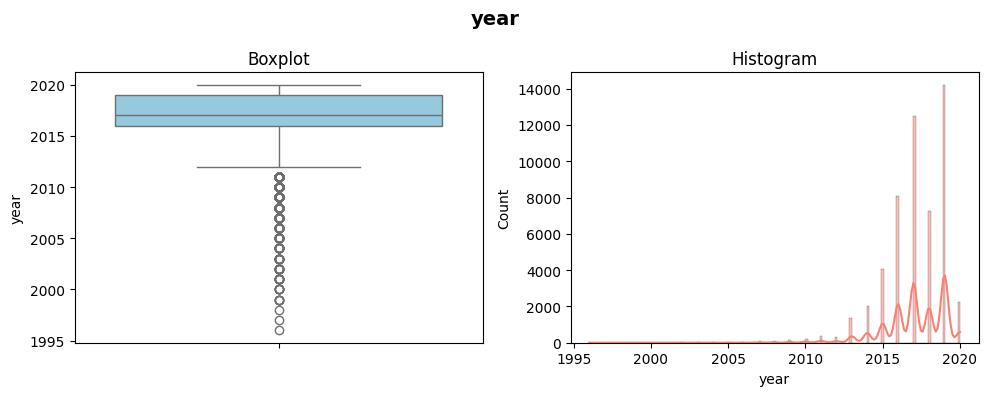

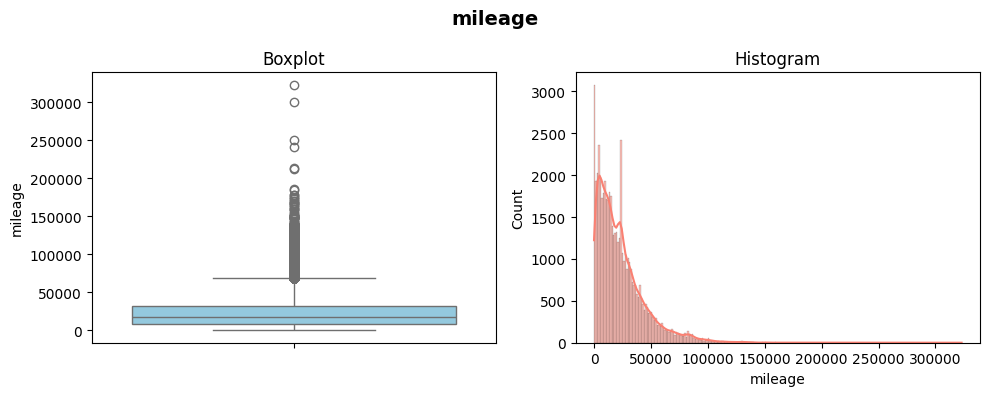

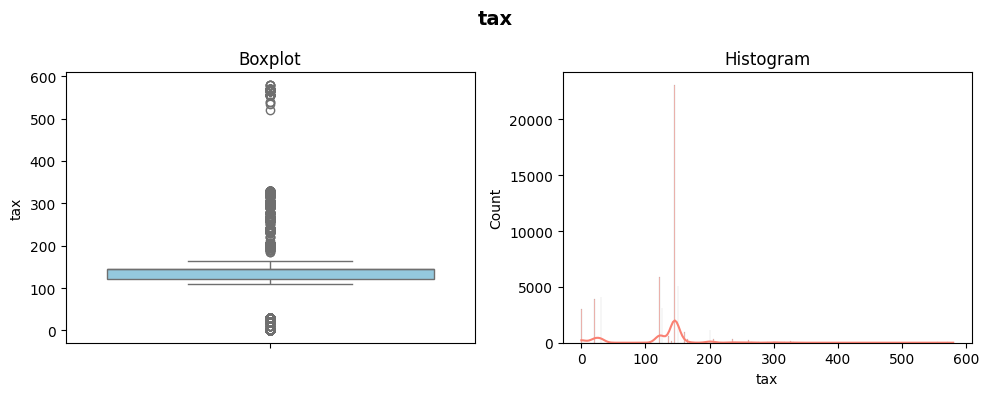

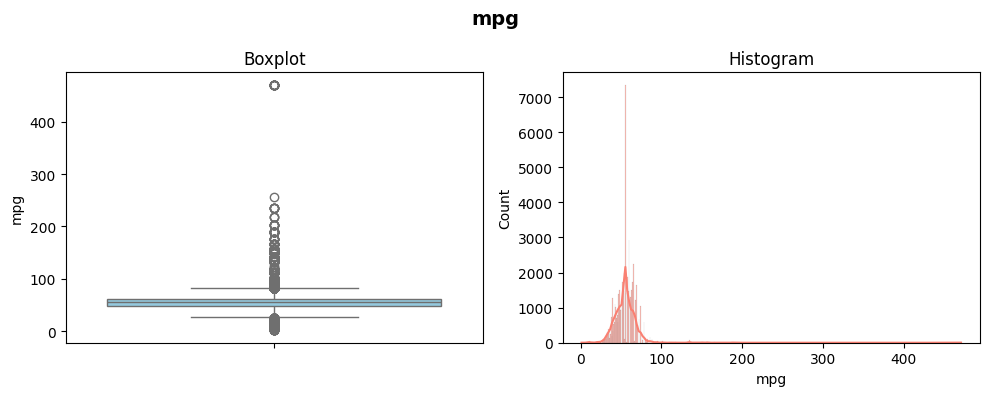

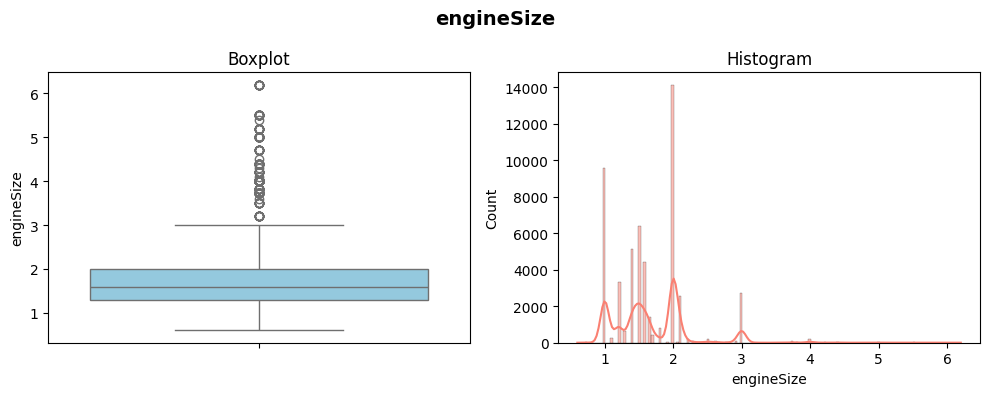

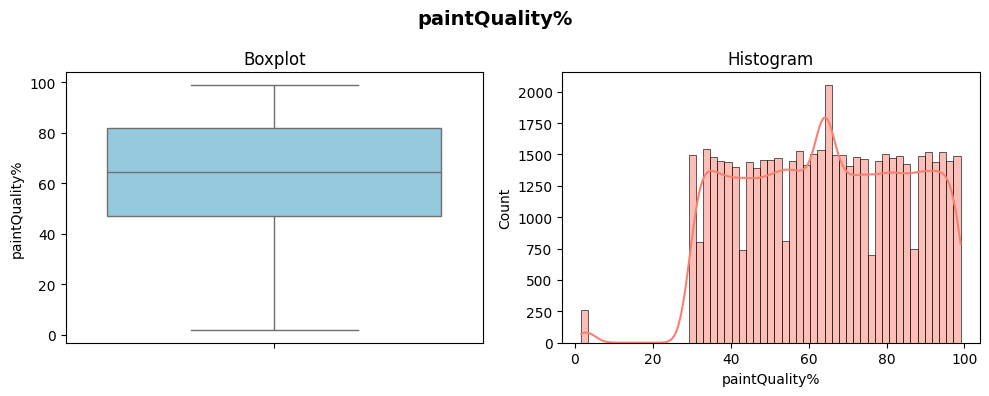

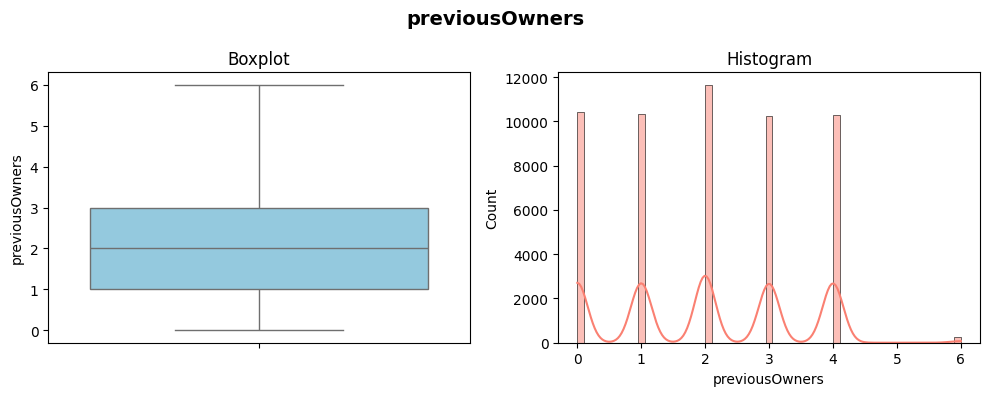

In [111]:
plot_nums(X_train, num_cols)

## **5.5 Outlier Treatment & Skewness Correction**


### **5.5.1 Outlier & Skewness Strategy (Training Phase)**

In [112]:
def outliers_skews_train(X):
    """
    Purpose:
        Apply outlier correction and skew reduction transformations to the
        training dataset, while recording all thresholds and operations used
        so that the exact same transformations can be applied later to the
        validation and test datasets without recalculating parameters.

    Overview of Operations:
        - mileage:
            Apply log1p transformation to reduce skewness in long-tailed
            distributions common in car mileage data.
        - tax:
            Identify extreme values using the 97.5th percentile and cap all
            values above this threshold (upper clipping).
        - mpg:
            Apply similar upper clipping based on the 97.5th percentile to
            remove unrealistically high fuel efficiency values.
        - engineSize:
            Apply bilateral clipping using the 1st and 99th percentiles to
            remove extreme small/large engine sizes while preserving most data.

    Returns:
        X (pd.DataFrame):
            A transformed copy of the dataset where outliers and skew-heavy
            features have been adjusted.
        outlier_info (dict):
            A dictionary containing all thresholds and transformation flags
            required to reproduce the same preprocessing steps during inference.

    Notes:
        This function must be used only on the training data. The resulting
        outlier_info dictionary should be passed to the corresponding
        outliers_skews_test() function to ensure consistent preprocessing of
        new or unseen data, avoiding data leakage.
    """

    X = X.copy()
    outlier_info = {}

    if "mileage" in X.columns:
        X["mileage"] = np.log1p(X["mileage"])
        outlier_info["mileage"] = {"log_transform": True}

    if "tax" in X.columns:
        upper = X["tax"].quantile(0.975)
        X["tax"] = X["tax"].clip(upper=upper)
        outlier_info["tax"] = {"upper": upper}

    if "mpg" in X.columns:
        upper = X["mpg"].quantile(0.975)
        X["mpg"] = X["mpg"].clip(upper=upper)
        outlier_info["mpg"] = {"upper": upper}

    if "engineSize" in X.columns:
        lower = X["engineSize"].quantile(0.01)
        upper = X["engineSize"].quantile(0.99)
        X["engineSize"] = X["engineSize"].clip(lower=lower, upper=upper)
        outlier_info["engineSize"] = {"lower": lower, "upper": upper}

    return X, outlier_info

### **5.5.2 Consistent Application to Validation/Test Data**

In [113]:
def outliers_skews_test(X, outlier_info):
    """
    Purpose:
        Apply the exact same outlier and skew corrections used during training
        to a new dataset (validation or test) using the thresholds and
        transformation rules previously recorded in outlier_info.
        No new statistics are computed here to avoid data leakage.

    Overview of Operations:
        - mileage:
            If log1p transformation was applied during training, apply the same
            transformation to preserve consistency in feature scaling.
        - tax:
            Apply upper clipping using the threshold recorded in outlier_info.
        - mpg:
            Apply upper clipping using the training-derived threshold.
        - engineSize:
            Apply bilateral clipping using the stored lower and upper bounds.

    Inputs:
        X (pd.DataFrame):
            New data (validation or test) to preprocess.
        outlier_info (dict):
            Dictionary containing all thresholds and transformation flags
            computed during training by outliers_skews_train().

    Returns:
        X (pd.DataFrame):
            A transformed copy of the dataset with the same preprocessing rules
            applied as during training, guaranteeing consistent feature scaling
            and preventing data leakage.

    Notes:
        This function must not compute new thresholds (quantiles, means, etc.).
        Its only responsibility is to enforce the transformations defined
        during training, ensuring reproducibility and consistent model behavior.
    """

    X = X.copy()

    if "mileage" in outlier_info and "mileage" in X.columns:
        if outlier_info["mileage"].get("log_transform", False):
            X["mileage"] = np.log1p(X["mileage"])

    if "tax" in outlier_info and "tax" in X.columns:
        X["tax"] = X["tax"].clip(upper=outlier_info["tax"]["upper"])

    if "mpg" in outlier_info and "mpg" in X.columns:
        X["mpg"] = X["mpg"].clip(upper=outlier_info["mpg"]["upper"])

    if "engineSize" in outlier_info and "engineSize" in X.columns:
        X["engineSize"] = X["engineSize"].clip(
            lower=outlier_info["engineSize"]["lower"],
            upper=outlier_info["engineSize"]["upper"]
        )

    return X


### **5.5.3 Application of Outlier & Skewness Corrections**

In [114]:
X_train, outlier_info = outliers_skews_train(X_train)
X_val = outliers_skews_test(X_val, outlier_info)

In [115]:
X_train_num = X_train[num_cols].copy()
X_train_cat = X_train[cat_cols].copy()

X_val_num = X_val[num_cols].copy()
X_val_cat = X_val[cat_cols].copy()

## **5.6 Feature Scaling (Numerical Variables)**

In [116]:
scaler = MinMaxScaler()
scaler.fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled

array([[0.95833333, 0.63204739, 0.61702128, ..., 0.15      , 0.45563467,
        0.33333333],
       [0.95833333, 0.66317479, 0.57446809, ..., 0.5       , 0.77403703,
        0.5       ],
       [1.        , 0.14215399, 0.61702128, ..., 0.        , 0.29129797,
        0.        ],
       ...,
       [0.79166667, 0.84176999, 0.08510638, ..., 0.        , 0.68159764,
        0.16666667],
       [0.875     , 0.81978055, 0.53191489, ..., 0.2       , 0.68159764,
        0.66666667],
       [0.79166667, 0.83355055, 0.53191489, ..., 0.55      , 0.53780302,
        0.        ]])

In [117]:
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)
X_train_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,
39423,0.958333,0.632047,0.617021,0.604651,0.15,0.455635,0.333333
9016,0.958333,0.663175,0.574468,1.000000,0.50,0.774037,0.500000
24121,1.000000,0.142154,0.617021,0.715762,0.00,0.291298,0.000000
57460,0.916667,0.774445,0.617021,0.492248,0.20,0.609700,0.000000
1936,1.000000,0.609856,0.617021,0.361757,0.95,0.917832,0.166667
...,...,...,...,...,...,...,...
33819,0.875000,0.765346,0.516791,0.649871,0.20,0.969187,0.666667
46982,0.958333,0.327042,0.617021,0.538760,0.50,0.702140,0.333333
71103,0.791667,0.841770,0.085106,0.797158,0.00,0.681598,0.166667


In [118]:
X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_val.index)
X_val_num_scaled

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners
carID,,,,,,,
7082,0.958333,0.657676,0.617021,0.453488,0.50,0.835663,0.166667
40497,0.833333,0.790559,0.516791,0.698726,0.55,0.712411,0.500000
46065,0.791667,0.830727,1.000000,0.357881,1.00,0.424822,0.500000
17155,0.916667,0.764732,0.617021,0.687339,0.00,0.599429,0.666667
34462,0.916667,0.809777,0.617021,0.472868,0.75,0.619971,0.166667
...,...,...,...,...,...,...,...
50530,0.875000,0.766156,0.617021,0.779070,0.00,0.394008,0.333333
41012,0.958333,0.601197,0.617021,0.698726,0.50,0.876747,0.333333
68389,0.875000,0.810461,0.085106,0.815245,0.00,0.866476,0.333333


## **5.7 Preprocessing Summary**

At the end of this preprocessing stage, the dataset is fully prepared for model
training. Missing values were handled using training-derived statistics, highly
skewed variables were stabilised, and extreme outliers were clipped based on
robust quantile thresholds.

All numerical features were subsequently normalised using Min–Max scaling to
ensure comparable feature ranges and to support models sensitive to scale.

Most importantly, every transformation applied to the validation data strictly
reused parameters learned from the training set, guaranteeing a leakage-free
pipeline and realistic performance estimates.

The resulting processed datasets are now suitable for direct integration into
the modelling pipeline.


# **6 FEATURE SELECTION**

## **6.1 Correlation**

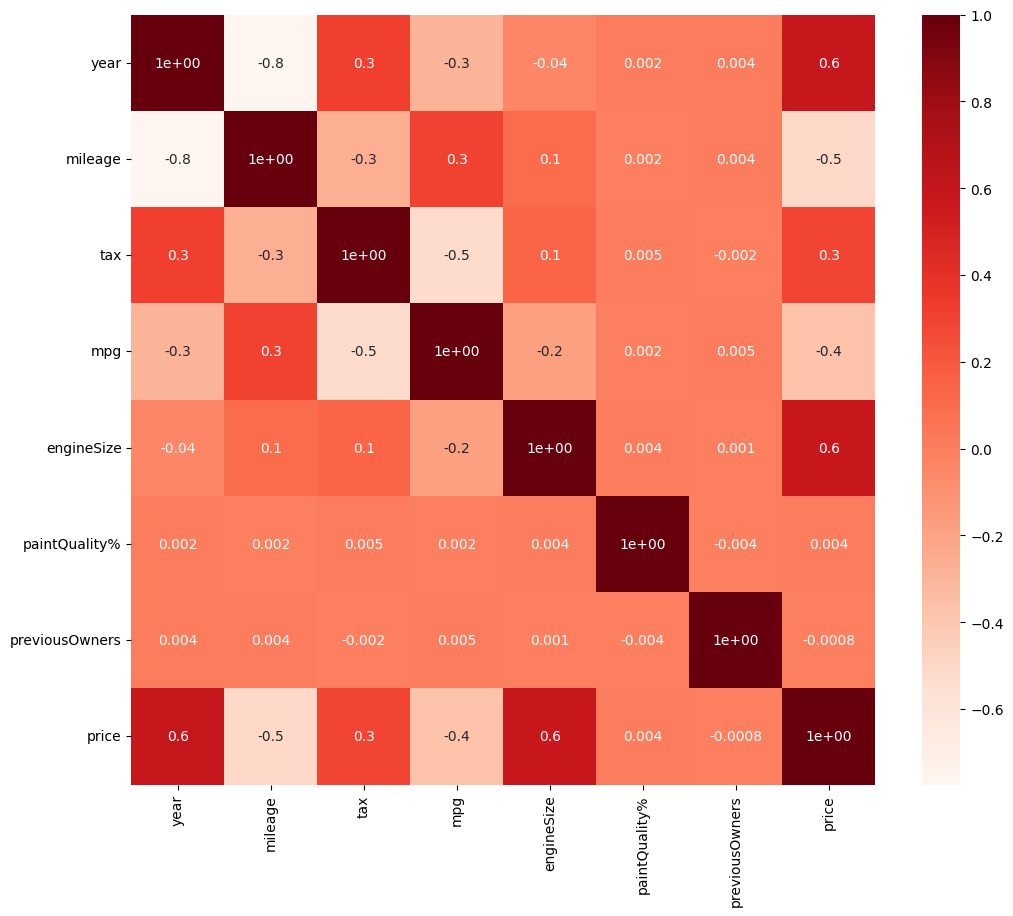

In [119]:
corr = X_train_num_scaled.assign(price=y_train).corr(method='spearman')
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
cor_heatmap(corr)

## **6.2 Estimating Numerical Feature Relevance Using Mutual Information Scores**

In [120]:
mi_scores = mutual_info_regression(X_train_num_scaled, y_train, random_state=0)
mi_scores = pd.Series(mi_scores, index=X_train_num_scaled.columns)
mi_scores.sort_values(ascending=False, inplace=True)
print(mi_scores)

engineSize        0.379613
mpg               0.364743
year              0.327638
mileage           0.304339
tax               0.190054
previousOwners    0.005993
paintQuality%     0.000000
dtype: float64


## **6.3 Chi-Square Test for Categorical Predictor Significance**

In [121]:
def TestIndependence(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

for var in X_train_cat:
    TestIndependence(X_train_cat[var],y_train, var)

Brand is IMPORTANT for Prediction
model is IMPORTANT for Prediction
transmission is IMPORTANT for Prediction
fuelType is NOT an important predictor. (Discard fuelType from model)


## **6.4 Cramér’s V: Association Metric for Categorical Predictors**

In [122]:
def cramers_v(x, y, var):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    result =  np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
    print(f"{var}: {result}")

for var in X_train_cat:
    cramers_v(X_train_cat[var],y_train, var)

Brand: 0.4933647476641014
model: 0.4781827026647914
transmission: 0.46768556858018623
fuelType: 0.4022624471229654


## **6.5 Mutual Information for Categorical Variables via Label Encoding**

In [123]:
def mutual_info(X, y, var):
    le = LabelEncoder()
    X_encoded = le.fit_transform(X.astype(str)).reshape(-1, 1)

    mi = mutual_info_classif(X_encoded, y, discrete_features=True, random_state=0)
    print(f"{var}: {mi[0]:.4f}")

for var in X_train_cat:
    mutual_info(X_train_cat[var],y_train, var)

Brand: 0.7444
model: 1.9133
transmission: 0.4439
fuelType: 0.2402


## **6.6 Teste ANOVA para Avaliar a Influência das Variáveis Categóricas na Variável Alvo**

In [124]:
def anova(X_col, y, var):
    groups = [y[X_col == level] for level in X_col.dropna().unique()]

    # Perform one-way ANOVA
    f_stat, p_val = f_oneway(*groups)

    print(f"{var.upper()}")
    print(f"  F-stat:  {f_stat:.3f}")
    print(f"  p-value: {p_val:.6f}")
    print("\n")  # line spacing between variables

    return pd.Series({"F-stat": f_stat, "p-value": p_val}, name=var)


for var in X_train_cat:
    anova(X_train_cat[var],y_train, var)

BRAND
  F-stat:  2381.016
  p-value: 0.000000


MODEL
  F-stat:  360.055
  p-value: 0.000000


TRANSMISSION
  F-stat:  4553.605
  p-value: 0.000000


FUELTYPE
  F-stat:  516.946
  p-value: 0.000000




In [125]:
"""ANOVA says: “These features cause significant average price differences.”

MI says: “These features explain uncertainty in price (model gives the most info).”

Cramer’s V says: “These variables have moderate categorical association strength.”"""

'ANOVA says: “These features cause significant average price differences.”\n\nMI says: “These features explain uncertainty in price (model gives the most info).”\n\nCramer’s V says: “These variables have moderate categorical association strength.”'

## **6.7 Seleção de Variáveis Numéricas com RFE e Avaliação do RMSE**

In [126]:
model = LinearRegression()

In [127]:
rfe = RFE(estimator = model, n_features_to_select = 4)

In [128]:
X_rfe = rfe.fit_transform(X = X_train_num_scaled, y = y_train)

In [129]:
X_train_num_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners'],
      dtype='object')

In [130]:
rfe.support_

array([ True,  True, False,  True,  True, False, False])

In [131]:
rfe.ranking_

array([1, 1, 2, 1, 1, 3, 4])

In [132]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

,0
year,True
mileage,True
tax,False
mpg,True
engineSize,True
paintQuality%,False
previousOwners,False


In [133]:
print(X_train_num_scaled.shape)
print(X_val_num_scaled.shape)
print(y_train.shape)
print(y_val.shape)


(53181, 7)
(22792, 7)
(53181,)
(22792,)


In [134]:
nof_list = np.arange(1, len(X_train_num_scaled.columns) + 1)
best_score = np.inf
best_n = 0

train_score_list = []
val_score_list = []

for n in nof_list:
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=n)

    # Fit RFE on training data
    X_train_rfe = rfe.fit_transform(X_train_num_scaled, y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)

    # Fit model
    model.fit(X_train_rfe, y_train)

    # Predict
    y_train_pred = model.predict(X_train_rfe)
    y_val_pred = model.predict(X_val_rfe)

    # Compute RMSE manually
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Store negated RMSE (so higher = better for plotting)
    train_score_list.append(-train_rmse)
    val_score_list.append(-val_rmse)

    # Track best score (lowest RMSE)
    if val_rmse < best_score:
        best_score = val_rmse
        best_n = n

print(f"Optimum number of features: {best_n}")
print(f"Lowest validation RMSE ({best_n} features): {best_score:.4f}")


Optimum number of features: 5
Lowest validation RMSE (5 features): 5378.4385


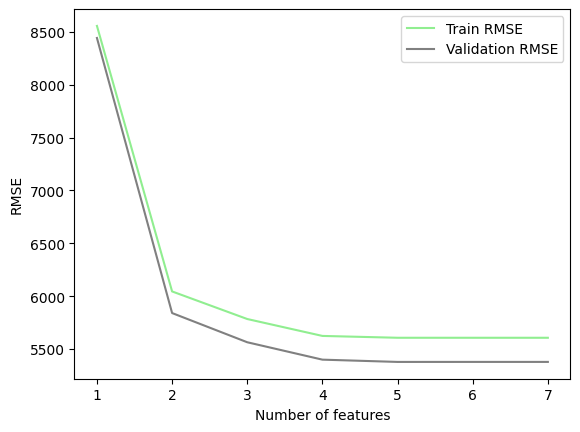

'Acho que há colinearidade entre variáveis como vimos antes, acho 4 sao suifciente'

In [135]:
plt.plot(nof_list, [-s for s in train_score_list], label='Train RMSE', color='lightgreen')
plt.plot(nof_list, [-s for s in val_score_list], label='Validation RMSE', color='gray')
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.legend()
plt.show()

"""Acho que há colinearidade entre variáveis como vimos antes, acho 4 sao suifciente"""

## **6.8 Seleção de Variáveis com LassoCV**

In [136]:
reg = LassoCV()

In [137]:
reg.fit(X_train_num_scaled, y_train)

LassoCV()

In [138]:
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
coef.sort_values()

,0
mileage,-14141.696977
mpg,-11896.597076
tax,-2172.830153
paintQuality%,-107.629734
previousOwners,-20.759555
engineSize,22294.266756
year,42233.546583


In [139]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 0 variables


In [140]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

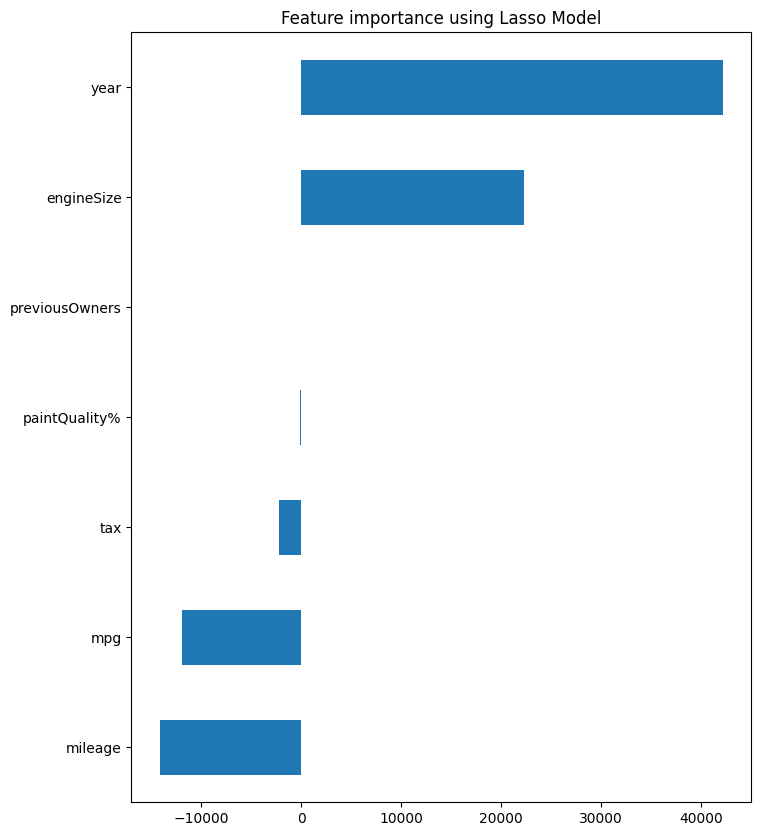

In [141]:
# CODE HERE
plot_importance(coef,'Lasso')

## **6.9 Feature Selection Summary: Numerical and Categorical Predictors**


Numerical Data
| Feature            | Spearman | Mutual Info | RFE (LR) | Lasso | Decision     |
| ------------------ | -------- | ----------- | -------- | ----- | ------------ |
| **year**           | ✅        | ✅           | ✅        | ✅     | **Keep**     |
| **mileage**        | ❌        | ✅           | ✅        | ❌     | **Keep**     |
| **tax**            | ✅        | ❌           | ❌        | ❌     | Try          |
| **mpg**            | ❌        | ✅           | ✅        | ✅     | **Keep**     |
| **engineSize**     | ✅        | ✅           | ✅        | ✅     | **Keep**     |
| **paintQuality%**  | ❌        | ❌           | ❌        | ❌     | Discard      |
| **previousOwners** | ❌        | ❌           | ❌        | ❌     | Discard      |

Categorical Data
| Feature          | Chi-Square | Cramér’s V | ANOVA F-test | Decision |
| ---------------- | ---------- | ---------- | ------------ | -------- |
| **brand**        | ✅          | ✅          | ✅            | **Keep** |
| **model**        | ✅          | ✅          | ✅            | **Keep** |
| **transmission** | ✅          | ✅          | ✅            | **Keep** |
| **fuelType**     | ❌          | ❌          | ✅            | Discard  |

Conclusion:

The most predictive features for our car price model appear to be:

Numerical: year, engineSize, mpg

Categorical: brand, model, transmission


# **7. MODEL SELECTION**

### Model Selection Strategy

This section implements a controlled and reproducible model selection
procedure. A fixed train–validation split is enforced via PredefinedSplit to
ensure that all candidate models are evaluated on the exact same validation
set, mirroring a Kaggle-style evaluation setup.

A unified, leakage-safe preprocessing function is used throughout the model
selection process, guaranteeing that all transformations are learned only
from training data and consistently applied during validation.

Different preprocessing rules (notably outlier handling) are conditionally
applied depending on the model family, reflecting known inductive biases of
tree-based versus linear and neural models.


## **7.0 Initial Setup**


In [142]:
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor


RANDOM_SEED = 1907



## **7.1 Train–Validation Split and Validation Strategy**

In [143]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    shuffle=True,
    random_state=RANDOM_SEED
)

# PredefinedSplit para forçar o mesmo validation set durante RandomizedSearchCV
test_fold = np.concatenate([
    -1 * np.ones(len(X_train)),
     0 * np.ones(len(X_val))
])

ps = PredefinedSplit(test_fold)

# --------------------------------------------------
# Target vector aligned with PredefinedSplit
# --------------------------------------------------
y_train_val_full = pd.concat(
    [y_train, y_val],
    axis=0
).reset_index(drop=True)



## **7.2 Unified Custom Preprocessing (Leakage-Safe)**

In [144]:
def preprocess_for_search(
    X,
    int_cols,
    float_cols,
    cat_cols,
    ohe,
    apply_outliers=True,
    fit=True,
    fill_values=None,
    outlier_info=None
):
    """
    Unified, leakage-safe preprocessing pipeline used for:
    - model selection
    - final training
    - validation / test prediction

    Steps:
    1. Numerical missing value imputation (leakage-safe)
    2. Optional outlier & skew correction
    3. One-hot encoding (categorical variables)

    Returns:
    - X_final: preprocessed feature matrix
    - artifacts: dict with learned preprocessing objects
    """

    X = X.copy()
    artifacts = {}

    # --------------------------------------------------
    # 1. Numerical imputation (USING EXISTING fill_nans)
    # --------------------------------------------------
    if fit:
        X, fill_values = fill_nans(X, int_cols, float_cols)
        artifacts["fill_values"] = fill_values
    else:
        X = fill_nans(X, int_cols, float_cols, fill_values)

    # --------------------------------------------------
    # 2. Optional outlier & skew correction
    # --------------------------------------------------
    if apply_outliers:
        if fit:
            X, outlier_info = outliers_skews_train(X)
            artifacts["outlier_info"] = outlier_info
        else:
            X = outliers_skews_test(X, outlier_info)

    # --------------------------------------------------
    # 3. One-Hot Encoding (categorical)
    # --------------------------------------------------
    if fit:
        ohe.fit(X[cat_cols])

    encoded = ohe.transform(X[cat_cols])
    encoded_cols = ohe.get_feature_names_out(cat_cols)

    X_encoded = pd.DataFrame(
        encoded,
        columns=encoded_cols,
        index=X.index
    )

    # --------------------------------------------------
    # 4. Rebuild final dataset
    # --------------------------------------------------
    X_final = pd.concat(
        [X.drop(columns=cat_cols), X_encoded],
        axis=1
    )

    X_final.columns = X_final.columns.astype(str)

    return X_final, artifacts



## **7.3 Candidate Models and Hyperparameter Search Spaces**

In [145]:
## 7.3 — Modelos e Espaços de Hiperparâmetros

models = {
    "RandomForest": RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),

    "GradientBoosting": GradientBoostingRegressor(
        random_state=RANDOM_SEED
    ),

    "HistGradientBoosting": HistGradientBoostingRegressor(
        random_state=RANDOM_SEED
    ),

    "ExtraTrees": ExtraTreesRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1
    ),

    "MLP": MLPRegressor(
        random_state=RANDOM_SEED,
        max_iter=400,
        early_stopping=True,
        n_iter_no_change=10,
        validation_fraction=0.1,
        solver="adam",
        learning_rate_init=0.001
    ),

    "Ridge": Ridge()
}


param_spaces = {
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"]
    },

    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [2, 3, 4]
    },

    "HistGradientBoosting": {
        "max_iter": [100, 200, 300],
        "learning_rate": [0.05, 0.1],
        "max_depth": [None, 10, 20],
        "min_samples_leaf": [20, 50]
    },

    "ExtraTrees": {
        "n_estimators": [200, 400, 600],
        "max_depth": [None, 20, 30],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"]
    },

    "MLP": {
        "hidden_layer_sizes": [(32,), (64,), (32, 32)],
        "alpha": [0.0001, 0.001, 0.01]
    },

    "Ridge": {
        "alpha": [0.1, 1.0, 10.0]
    }
}



## **7.4 RandomizedSearchCV with Controlled Validation**


In [146]:
results = []

print("\n===== MODEL SELECTION STARTED =====\n")

for name, model in models.items():
    print(f"\n### Running: {name} ###")

    # --------------------------------------------------
    # 7.5.1 — Outlier handling rule by model type
    # --------------------------------------------------
    if name in ["RandomForest", "ExtraTrees", "GradientBoosting", "HistGradientBoosting"]:
        apply_outliers = False   # tree-based models
    else:
        apply_outliers = True    # Ridge / MLP

    # --------------------------------------------------
    # 7.5.2 — Leakage-safe preprocessing
    #   fit  -> TRAIN only
    #   apply -> VALIDATION
    # --------------------------------------------------
    ohe_model = OneHotEncoder(
        drop="first",
        sparse_output=False,
        handle_unknown="ignore"
    )

    # ---- FIT preprocessing on TRAIN ----
    X_train_proc, artifacts = preprocess_for_search(
        X_train,
        int_cols=int_cols,
        float_cols=float_cols,
        cat_cols=cat_cols,
        ohe=ohe_model,
        apply_outliers=apply_outliers,
        fit=True
    )

    # --------------------------------------------------
    # Sanity checks on learned artifacts
    # --------------------------------------------------
    assert "fill_values" in artifacts, "Missing fill_values in preprocessing artifacts"
    if apply_outliers:
        assert "outlier_info" in artifacts, "Missing outlier_info while apply_outliers=True"

    # ---- APPLY preprocessing to VALIDATION ----
    X_val_proc, _ = preprocess_for_search(
        X_val,
        int_cols=int_cols,
        float_cols=float_cols,
        cat_cols=cat_cols,
        ohe=ohe_model,
        apply_outliers=apply_outliers,
        fit=False,
        fill_values=artifacts["fill_values"],
        outlier_info=artifacts.get("outlier_info")
    )

    # ---- Rebuild dataset for PredefinedSplit ----
    X_preprocessed_model = pd.concat(
        [X_train_proc, X_val_proc],
        axis=0
    ).reset_index(drop=True)

    # --------------------------------------------------
    # 7.5.3 — RandomizedSearchCV
    # --------------------------------------------------
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_spaces[name],
        n_iter=15,
        cv=ps,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_SEED
    )

    search.fit(X_preprocessed_model, y_train_val_full.values.ravel())

    best_mae = -search.best_score_

    print(f"{name} — Validation MAE: {best_mae:.4f}")
    print("Best params:", search.best_params_)
    print("Outlier handling:", apply_outliers)

    # --------------------------------------------------
    # 7.5.4 — Store results
    # --------------------------------------------------
    results.append({
        "model": name,
        "val_mae": best_mae,
        "best_params": search.best_params_,
        "estimator": search.best_estimator_,
        "apply_outliers": apply_outliers
    })

print("\n===== MODEL SELECTION COMPLETE =====")

results_sorted = sorted(results, key=lambda x: x["val_mae"])
best = results_sorted[0]

print("\n### BEST MODEL ###")
print(best)








===== MODEL SELECTION STARTED =====


### Running: RandomForest ###
Fitting 1 folds for each of 15 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForest — Validation MAE: 1477.3206
Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Outlier handling: False

### Running: GradientBoosting ###


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=15. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 1 folds for each of 12 candidates, totalling 12 fits
GradientBoosting — Validation MAE: 1857.1674
Best params: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1}
Outlier handling: False

### Running: HistGradientBoosting ###


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 1 folds for each of 15 candidates, totalling 15 fits
HistGradientBoosting — Validation MAE: 1486.8313
Best params: {'min_samples_leaf': 50, 'max_iter': 300, 'max_depth': None, 'learning_rate': 0.1}
Outlier handling: False

### Running: ExtraTrees ###


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Fitting 1 folds for each of 15 candidates, totalling 15 fits
ExtraTrees — Validation MAE: 1455.9408
Best params: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Outlier handling: False

### Running: MLP ###
Fitting 1 folds for each of 9 candidates, totalling 9 fits


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MLP — Validation MAE: 2278.5163
Best params: {'hidden_layer_sizes': (32, 32), 'alpha': 0.001}
Outlier handling: True

### Running: Ridge ###


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=15. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Ridge — Validation MAE: 2498.1259
Best params: {'alpha': 0.1}
Outlier handling: True

===== MODEL SELECTION COMPLETE =====

### BEST MODEL ###
{'model': 'ExtraTrees', 'val_mae': np.float64(1455.9407852466336), 'best_params': {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}, 'estimator': ExtraTreesRegressor(max_features='sqrt', n_estimators=600, n_jobs=-1,
                    random_state=1907), 'apply_outliers': False}



### Step 1 — Save the Model Selection Artifacts

After completing the model selection phase, the following critical artifacts are defined and must be preserved (either mentally or documented in markdown), as they will be used consistently in the subsequent stages of the pipeline:

- Winning model  
```python
best["model"] == "ExtraTrees"
```

- Best hyperparameters found


```python
best["best_params"]
```
- Associated preprocessing rule


```python
apply_outliers = False
```

# **8. EXTRA TREES — FINAL HYPERPARAMETER TUNING**

## **8.0 ExtraTrees Final Tuning — Strategy**

ExtraTrees Final Tuning Strategy

This section performs a focused, final hyperparameter optimization of the
ExtraTrees model selected during model comparison. A reduced but expressive
search space is used to balance performance gains and computational cost.

All preprocessing steps remain strictly leakage-safe, with transformations
learned exclusively from training data and reused consistently for validation
and test inference. The final model is retrained on the full dataset and
stabilized via an increased number of trees to reduce variance prior to
submission.


## **8.1 Extra Trees Final Tunning - Initial Setup**

In [147]:
# ==========================================================
# 8.0 — EXTRA TREES FINAL TUNING: SETUP
# ==========================================================

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
import numpy as np

RANDOM_SEED = 1907

# Garantir que usamos X_train, X_val, y_train, y_val criados antes
print("Training size:", len(X_train))
print("Validation size:", len(X_val))

# PredefinedSplit para garantir validação consistente
test_fold = np.concatenate([
    -1 * np.ones(len(X_train)),   # treino
     0 * np.ones(len(X_val))      # validação
])

ps = PredefinedSplit(test_fold)

print("PredefinedSplit ready.")


Training size: 53181
Validation size: 22792
PredefinedSplit ready.


## **8.2 Preprocessing for ExtraTrees**

In [148]:
# ==========================================================
# 8.3 — LEAKAGE-SAFE PREPROCESSING FOR EXTRATREES (TRAIN → VAL)
# ==========================================================

# Dedicated OneHotEncoder (fit ONLY on TRAIN)
ohe_extra = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

# --------------------------------------------------
# 1) FIT preprocessing ONLY on TRAIN
# --------------------------------------------------
X_train_proc_extra, artifacts_extra = preprocess_for_search(
    X_train,
    int_cols=int_cols,
    float_cols=float_cols,
    cat_cols=cat_cols,
    ohe=ohe_extra,
    apply_outliers=False,   # ExtraTrees → no outlier handling
    fit=True
)

# --------------------------------------------------
# 2) APPLY preprocessing to VALIDATION (NO FIT)
# --------------------------------------------------
X_val_proc_extra, _ = preprocess_for_search(
    X_val,
    int_cols=int_cols,
    float_cols=float_cols,
    cat_cols=cat_cols,
    ohe=ohe_extra,  # reuse fitted encoder
    apply_outliers=False,
    fit=False,
    fill_values=artifacts_extra["fill_values"],
    outlier_info=artifacts_extra.get("outlier_info")
)

# --------------------------------------------------
# 3) Rebuild dataset for PredefinedSplit
# --------------------------------------------------
X_preproc_extra = pd.concat(
    [X_train_proc_extra, X_val_proc_extra],
    axis=0
).reset_index(drop=True)

y_train_val_full = pd.concat(
    [y_train, y_val],
    axis=0
).reset_index(drop=True)

print("Preprocessing completed (leakage-safe).")
print("Shape:", X_preproc_extra.shape)
print("Artifacts available:", list(artifacts_extra.keys()))




Preprocessing completed (leakage-safe).
Shape: (75973, 223)
Artifacts available: ['fill_values']


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## **8.3 Final Hyperparameter Search (RandomizedSearchCV)**

In [149]:
# ================================================================
# 8.3 — RANDOMIZEDSEARCHCV FINAL PARA EXTRATREES
# ================================================================
"""
README
------
Esta secção executa a pesquisa final de hiperparâmetros para o modelo ExtraTrees,
usando um espaço de procura equilibrado (Opção C).
Objetivos:
 - Reduzir o tempo total de treino (≈20–25 min)
 - Manter desempenho semelhante ao RandomizedSearchCV completo
 - Evitar configurações demasiado pesadas (ex.: max_features='log2', max_depth demasiado ampla)

A validação continua a ser feita com o PredefinedSplit definido anteriormente.
"""

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV

# ================================================================
# 8.3.1 Base Model Definition
# ================================================================
extra_final_model = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# ================================================================
# 8.3.2 Optimized Hyperparameter Space
# ================================================================
extra_param_space_C = {
    "n_estimators": [200, 400, 600],     # quantidade de árvores
    "max_depth": [None, 30],             # profundidade controlada
    "min_samples_split": [2, 5],         # divisão mínima
    "min_samples_leaf": [1, 2],          # folhas mínimas
    "max_features": ["sqrt"]             # mais rápido e estável
}

# ================================================================
# 8.3.3 RandomizedSearchCV Configuration
# ================================================================
print("\n==== EXTRA TREES — EXPANDED HYPERPARAMETER SEARCH (OPTION C) ====\n")
print("Running RandomizedSearchCV with optimized search space...\n")

search_extra_C = RandomizedSearchCV(
    estimator=extra_final_model,
    param_distributions=extra_param_space_C,
    n_iter=30,                                 # → reduz tempo pela metade
    cv=ps,                                     # PredefinedSplit
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_SEED
)

# ================================================================
# 8.3.4 Search Execution and Results
# ================================================================
search_extra_C.fit(X_preproc_extra, y_train_val_full)

best_mae_C = -search_extra_C.best_score_
best_params_C = search_extra_C.best_params_

# ================================================================
# 8.3.5 — Printing results
# ================================================================
print("\n===== BEST RESULT — EXTRA TREES (OPTION C) =====")
print("Best MAE:", best_mae_C)
print("Best Params:", best_params_C)



/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 24 is smaller than n_iter=30. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



==== EXTRA TREES — EXPANDED HYPERPARAMETER SEARCH (OPTION C) ====

Running RandomizedSearchCV with optimized search space...

Fitting 1 folds for each of 24 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



===== BEST RESULT — EXTRA TREES (OPTION C) =====
Best MAE: 1455.9407852466336
Best Params: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}


## **8.4 Retraining ExtraTrees on the Full Dataset**

In [150]:
# ==========================================================
# 8.4 — RE-TREINO FINAL DO EXTRA TREES (VARIANCE REDUCTION)
# ==========================================================
"""
README
------
Nesta célula, o modelo ExtraTrees vencedor é re-treinado
no DATASET COMPLETO (X, y), mantendo todos os hiperparâmetros
estruturais encontrados na fase de model selection.

A única alteração intencional é o aumento de n_estimators,
com o objetivo de reduzir variância e estabilizar previsões,
sem alterar a decisão do modelo vencedor.

Esta etapa NÃO faz parte da model selection.
É uma otimização final antes da submissão.
"""

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder

# --------------------------------------------------
# Parâmetros vencedores (da model selection)
# --------------------------------------------------
best_params_extra = {
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "sqrt"
}

# --------------------------------------------------
# Encoder FINAL (fit apenas aqui)
# --------------------------------------------------
final_ohe = OneHotEncoder(
    drop="first",
    sparse_output=False,
    handle_unknown="ignore"
)

print("Preprocessing full training data...")

# --------------------------------------------------
# Pré-processar TODO o dataset de treino (fit=True)
# --------------------------------------------------
X_full_processed_extra, artifacts_extra = preprocess_for_search(
    X,
    int_cols=int_cols,
    float_cols=float_cols,
    cat_cols=cat_cols,
    ohe=final_ohe,
    apply_outliers=False,   # árvores → sem outliers
    fit=True
)

# Guardar colunas usadas no treino (CRÍTICO para alinhar o test)
train_feature_cols_extra = X_full_processed_extra.columns.tolist()

# --------------------------------------------------
# Re-treino com mais árvores (variance reduction)
# --------------------------------------------------
final_extra = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    n_estimators=1000,   # aumento deliberado
    **best_params_extra
)

print("Training final ExtraTrees model...")
final_extra.fit(X_full_processed_extra, y.values.ravel())

print("Final ExtraTrees model trained successfully.")
print("Number of trees:", final_extra.n_estimators)
print("Total training features:", len(train_feature_cols_extra))



Preprocessing full training data...
Training final ExtraTrees model...
Final ExtraTrees model trained successfully.
Number of trees: 1000
Total training features: 229


## **8.5 Test Set Preprocessing (Inference Only)**

In [151]:
# ==========================================================
# 8.5 — PREPARING TEST SET (NO FIT!)
# ==========================================================
"""
README
------
O test.csv é transformado usando EXATAMENTE os artifacts
aprendidos no treino final do ExtraTrees.
"""

from google.colab import files

# --------------------------------------------------
# Load test.csv
# --------------------------------------------------
uploaded = files.upload()
test_df = pd.read_csv(list(uploaded.keys())[0])

# --------------------------------------------------
# 1) Clean inicial
# --------------------------------------------------
test_clean = clean_df(test_df.copy(), valid_models)

# --------------------------------------------------
# 2) Preprocess SEM FIT (reuse artifacts)
# --------------------------------------------------
X_test_processed_extra, _ = preprocess_for_search(
    test_clean,
    int_cols=int_cols,
    float_cols=float_cols,
    cat_cols=cat_cols,
    ohe=ohe_extra,                             # encoder treinado
    apply_outliers=False,
    fit=False,
    fill_values=artifacts_extra["fill_values"],
    outlier_info=artifacts_extra.get("outlier_info")
)

# --------------------------------------------------
# 3) Alinhar features
# --------------------------------------------------
X_test_processed_extra = X_test_processed_extra.reindex(
    columns=train_feature_cols_extra,
    fill_value=0
)

print("Test processed successfully")
print("Test shape:", X_test_processed_extra.shape)


Saving test.csv to test.csv
Test processed successfully
Test shape: (32567, 229)


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## **8.6 Final Test Predictions**

In [152]:
# ==========================================================
# 8.6 — FINAL PREDICTIONS WITH EXTRA TREES
# ==========================================================
"""
README
------
Predictions on the processed test dataset using the ExtraTrees
model retrained on the full training data.

Guarantees:
- Column alignment
- No NaNs
- Deterministic inference
"""

# --------------------------------------------------
# Sanity checks
# --------------------------------------------------
assert "X_test_processed_extra" in globals(), "Test data not found"
assert "final_extra" in globals(), "Final model not found"

print("Test matrix shape:", X_test_processed_extra.shape)
print("Contains NaNs?", X_test_processed_extra.isna().sum().sum())

# --------------------------------------------------
# Predictions
# --------------------------------------------------
y_pred_extra = final_extra.predict(X_test_processed_extra)

print("Predictions completed successfully.")
print("Sample predictions:", y_pred_extra[:10])
print("Min prediction:", y_pred_extra.min())
print("Max prediction:", y_pred_extra.max())



Test matrix shape: (32567, 229)
Contains NaNs? 0
Predictions completed successfully.
Sample predictions: [10653.229 24570.154 14366.571 16895.037 24995.988 10309.506 14427.158
 14265.737  5502.458 17897.937]
Min prediction: 1808.08
Max prediction: 129335.379


## **8.7 — Exportar “submission_extra_trees.csv”**

In [153]:
# ==========================================================
# 8.7 — EXPORTAR RESULTADOS EM CSV
# ==========================================================

submission_extra = pd.DataFrame({
    "carID": test_clean.index,
    "price": y_pred_extra
})

submission_extra.to_csv("submission_extra_trees.csv", index=False)

print("Saved submission_extra_trees.csv")
display(submission_extra.head())



Saved submission_extra_trees.csv


,carID,price
0,89856,10653.229
1,106581,24570.154
2,80886,14366.571
3,100174,16895.037
4,81376,24995.988


# **9. MODEL BLENDING (EXTRATREES + RANDOM FOREST)**

## **9.0 Model Blending Strategy**

This section implements a simple yet effective model blending approach by
combining the predictions of two strong tree-based regressors: **ExtraTrees**
and **Random Forest**.

Both models are trained using the same leakage-safe preprocessing pipeline and
share an identical feature space, ensuring that their predictions are directly
comparable. While ExtraTrees typically offers lower bias, Random Forest tends to
provide more stable predictions. Blending their outputs helps reduce variance
and improve generalisation performance on unseen data.

Two blending strategies are evaluated:
1. **Simple averaging**, which provides a robust baseline ensemble.
2. **Weighted averaging**, which allows emphasising the stronger model while
   still benefiting from ensemble diversity.

All blending operations are performed strictly at inference time, without any
additional model fitting. The final blended predictions are then exported in a
Kaggle-compliant submission format.


In [154]:
# ==========================================================
# Load test.csv and preserve IDs (GLOBAL, ONCE)
# ==========================================================

test_df = pd.read_csv("test.csv")

# Kaggle-safe immutable IDs
test_ids = test_df["carID"].values

# Clean test data
test_clean = clean_df(test_df.copy(), valid_models)

print("Test data loaded.")
print("Test shape:", test_clean.shape)


Test data loaded.
Test shape: (32567, 11)


## **9.1 Test Set Preprocessing (Prediction Only)**

In [155]:
"""
README
------
Prepare test set using:
- SAME preprocessing as training
- NO fitting
- SAME feature space
"""

# --------------------------------------------------
# Sanity checks
# --------------------------------------------------
assert "final_ohe" in globals(), "Final OneHotEncoder not found"
assert "train_feature_cols_extra" in globals(), "Training feature columns not found"
assert "final_extra" in globals(), "Final ExtraTrees model not found"
assert "artifacts_extra" in globals(), "ExtraTrees training artifacts not found"
assert "test_ids" in globals(), "test_ids not found"

print("Preprocessing test set for blending...")


# --------------------------------------------------
# Preprocess test set (NO FIT!)
# --------------------------------------------------
X_test_tmp_extra, _ = preprocess_for_search(
    test_clean,
    int_cols=int_cols,
    float_cols=float_cols,
    cat_cols=cat_cols,
    ohe=final_ohe,                        #  FINAL encoder (trained on full data)
    apply_outliers=False,                 # tree-based model
    fit=False,
    fill_values=artifacts_extra["fill_values"],
    outlier_info=artifacts_extra.get("outlier_info")
)

# --------------------------------------------------
# Align columns with training feature space
# --------------------------------------------------
X_test_tmp_extra = X_test_tmp_extra.reindex(
    columns=train_feature_cols_extra,
    fill_value=0
)

print("Test set ready.")
print("Shape:", X_test_tmp_extra.shape)
print("NaNs:", X_test_tmp_extra.isna().sum().sum())


Preprocessing test set for blending...
Test set ready.
Shape: (32567, 229)
NaNs: 0


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## **9.2 Final RandomForest Training (Blend Partner)**

In [156]:

print("Training RandomForest for blending...")

final_rf = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt"
)

final_rf.fit(X_full_processed_extra, y)

print("RandomForest ready for blending.")


Training RandomForest for blending...
RandomForest ready for blending.


## **9.2 Final Histogram Gradient Boosting Training (Blend Partner)**

In [157]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoosting for blending...")

final_hgb = HistGradientBoostingRegressor(
    random_state=RANDOM_SEED,
    max_iter=300,
    learning_rate=0.1,
    max_depth=None,
    min_samples_leaf=50
)

final_hgb.fit(X_full_processed_extra, y)

print("HistGradientBoosting ready for blending.")


Training HistGradientBoosting for blending...
HistGradientBoosting ready for blending.


## **9.3 Blend Predictions (Simple Average)**

In [158]:
## **9.3 Blend Predictions and Submission (Simple Average)**

"""
README
------
Generate blended predictions (ExtraTrees + RandomForest)
using simple averaging and export a Kaggle-compliant
submission file.

Expected format:
- carID
- price
"""

# --------------------------------------------------
# Sanity checks
# --------------------------------------------------
assert "final_extra" in globals(), "Final ExtraTrees model not found"
assert "final_rf" in globals(), "Final RandomForest model not found"
assert "X_test_tmp_extra" in globals(), "Processed test matrix not found"
assert "test_ids" in globals(), "test_ids not found"

print("Generating blended predictions...")

# --------------------------------------------------
# Individual predictions
# --------------------------------------------------
y_pred_extra = final_extra.predict(X_test_tmp_extra)
y_pred_rf = final_rf.predict(X_test_tmp_extra)

# --------------------------------------------------
# Simple average blend
# --------------------------------------------------
y_pred_blend = 0.5 * y_pred_extra + 0.5 * y_pred_rf

print("Blending completed.")
print("Sample predictions:", y_pred_blend[:5])
print("Min / Max:", float(y_pred_blend.min()), float(y_pred_blend.max()))

# --------------------------------------------------
# Build submission dataframe (Kaggle-safe)
# --------------------------------------------------
submission = pd.DataFrame({
    "carID": test_ids,
    "price": y_pred_blend
})

# --------------------------------------------------
# Final validation
# --------------------------------------------------
assert submission.columns.tolist() == ["carID", "price"]
assert len(submission) == len(test_ids)

print("Submission preview:")
print(submission.head())
print("Submission shape:", submission.shape)

# --------------------------------------------------
# Save to CSV
# --------------------------------------------------
submission_path = "submission_blend_extratrees_rf.csv"
submission.to_csv(submission_path, index=False)

print(f"Submission file saved: {submission_path}")




Generating blended predictions...
Blending completed.
Sample predictions: [10939.06533333 24413.76616667 14254.07716667 16866.2285
 25604.14316667]
Min / Max: 1941.2358333333334 126554.19283333333
Submission preview:
    carID         price
0   89856  10939.065333
1  106581  24413.766167
2   80886  14254.077167
3  100174  16866.228500
4   81376  25604.143167
Submission shape: (32567, 2)
Submission file saved: submission_blend_extratrees_rf.csv


## **9.4 Blend Predictions (Weighted Average)**

In [159]:
## **9.4 Weighted Blend Predictions and Submission**

"""
README
------
Generate weighted blended predictions (ExtraTrees + RandomForest)
and export a Kaggle-compliant submission file.
"""

# --------------------------------------------------
# Sanity checks (hard fail)
# --------------------------------------------------
assert "final_extra" in globals(), "final_extra not found"
assert "final_rf" in globals(), "final_rf not found"
assert "X_test_tmp_extra" in globals(), "Processed test matrix not found"
assert "test_ids" in globals(), "test_ids not found"

# --------------------------------------------------
# Blend weights (5% ET + 95% RF)
# --------------------------------------------------
w_extra, w_rf = 0.05, 0.95
assert abs(w_extra + w_rf - 1.0) < 1e-9

print("Generating weighted blend predictions...")

# --------------------------------------------------
# Predictions
# --------------------------------------------------
y_test_extra = final_extra.predict(X_test_tmp_extra)
y_test_rf = final_rf.predict(X_test_tmp_extra)

y_test_blend = w_extra * y_test_extra + w_rf * y_test_rf

print("Done.")
print("n_preds:", len(y_test_blend))
print("min/max:", float(y_test_blend.min()), float(y_test_blend.max()))

# --------------------------------------------------
# Build submission (Kaggle-safe)
# --------------------------------------------------
assert len(y_test_blend) == len(test_ids), "Prediction / ID length mismatch"

submission = pd.DataFrame({
    "carID": test_ids,
    "price": y_test_blend
})

# Final checks
assert submission.columns.tolist() == ["carID", "price"]

print("Submission preview:")
print(submission.head())

# --------------------------------------------------
# Save
# --------------------------------------------------
out_path = "submission_blend_05ET_95RF.csv"
submission.to_csv(out_path, index=False)

print("Saved:", out_path)





Generating weighted blend predictions...
Done.
n_preds: 32567
min/max: 2057.223716666667 124051.12528333333
Submission preview:
    carID         price
0   89856  11196.318033
1  106581  24273.017117
2   80886  14152.832717
3  100174  16840.300850
4   81376  26151.482817
Saved: submission_blend_05ET_95RF.csv


## **9.5 Blend Predictions ET+RF+HGB**

In [160]:
"""
README
------
Generate blended predictions using:
- ExtraTrees
- RandomForest
- HistGradientBoosting

Strategy:
- Simple average of three strong but diverse models
"""

# --------------------------------------------------
# Sanity checks
# --------------------------------------------------
assert "final_extra" in globals()
assert "final_rf" in globals()
assert "final_hgb" in globals()
assert "X_test_tmp_extra" in globals()
assert "test_ids" in globals()

print("Generating blended predictions (ET + RF + HGB)...")

# --------------------------------------------------
# Individual predictions
# --------------------------------------------------
y_et = final_extra.predict(X_test_tmp_extra)
y_rf = final_rf.predict(X_test_tmp_extra)
y_hgb = final_hgb.predict(X_test_tmp_extra)

# --------------------------------------------------
# Simple average blend (3 models)
# --------------------------------------------------
y_pred_blend = (y_et + y_rf + y_hgb) / 3.0

print("Blending completed.")
print("Sample predictions:", y_pred_blend[:5])
print("Min / Max:", float(y_pred_blend.min()), float(y_pred_blend.max()))

# --------------------------------------------------
# Submission
# --------------------------------------------------
submission = pd.DataFrame({
    "carID": test_ids,
    "price": y_pred_blend
})

submission_path = "submission_blend_ET_RF_HGB.csv"
submission.to_csv(submission_path, index=False)

print("Submission saved:", submission_path)


Generating blended predictions (ET + RF + HGB)...
Blending completed.
Sample predictions: [11218.15459058 24359.4025454  13945.57666773 17031.48071044
 25708.65453785]
Min / Max: 1608.1308263256624 128193.33617045444
Submission saved: submission_blend_ET_RF_HGB.csv


## **9.6 Blend Predictions 0.2ET+0.4RF+0.4HGB**

In [161]:
"""
README
------
Weighted blend:
- ExtraTrees: 0.2
- RandomForest: 0.4
- HistGradientBoosting: 0.4
"""

# --------------------------------------------------
# Weights
# --------------------------------------------------
w_et, w_rf, w_hgb = 0.2, 0.4, 0.4
assert abs(w_et + w_rf + w_hgb - 1.0) < 1e-9

print("Generating weighted blended predictions...")

y_pred_weighted = (
    w_et * y_et +
    w_rf * y_rf +
    w_hgb * y_hgb
)

# --------------------------------------------------
# Submission
# --------------------------------------------------
submission = pd.DataFrame({
    "carID": test_ids,
    "price": y_pred_weighted
})

out_path = "submission_weighted_ET_RF_HGB.csv"
submission.to_csv(out_path, index=False)

print("Weighted submission saved:", out_path)


Generating weighted blended predictions...
Weighted submission saved: submission_weighted_ET_RF_HGB.csv


# **10 ANALYTICS INTERFACE FOR NEW-DATA INFERENCE**


In [162]:
# ==========================================================
# 10.0 — INFERENCE SANITY CHECK (PIPELINE ORIGINAL)
# ==========================================================
"""
README
------
Run this before any UI.

This cell verifies that the FINAL trained objects and preprocessing artifacts
exist in memory (produced by the pipeline) and are ready for inference.

If this cell fails, you must run the missing upstream section(s).
"""

required = [
    "final_extra",
    "final_rf",
    "final_hgb",
    "final_ohe",
    "artifacts_extra",
    "train_feature_cols_extra",
    "int_cols",
    "float_cols",
    "cat_cols",
    "valid_models",
    "clean_df",
    "preprocess_for_search",
]

missing = [name for name in required if name not in globals()]
assert not missing, f"Missing in globals(): {missing}"

print("All required objects found ✓  Ready for dashboard in the same notebook.")


All required objects found ✓  Ready for dashboard in the same notebook.


## **10.1 Single car Price Prediction Function**

In [163]:
# ==========================================================
# 10.1  SINGLE-CAR PREDICTION (PIPELINE ORIGINAL)
# ==========================================================
"""
README
------
Canonical inference function for the Cars4You project.

- Uses the SAME cleaning function: clean_df()
- Uses the SAME preprocessing: preprocess_for_search(fit=False)
- Reuses trained artifacts: final_ohe + artifacts_extra["fill_values"]
- Aligns feature space with training: train_feature_cols_extra
- Produces:
  - prediction per model (ET / RF / HGB)
  - weighted ensemble (ET 0.2 / RF 0.4 / HGB 0.4)
  - a model-disagreement indicator (std dev)
"""

import numpy as np
import pandas as pd

W_ET, W_RF, W_HGB = 0.2, 0.4, 0.4
assert abs(W_ET + W_RF + W_HGB - 1.0) < 1e-9

def predict_single_car_pipeline(
    brand,
    model,
    year,
    mileage,
    fuelType,
    transmission,
    engineSize,
    tax=None,
    mpg=None,
    paintQuality=None,
    previousOwners=None
):
    # --------------------------------------------------
    # 1) Build single-row DF (match training schema)
    # --------------------------------------------------
    input_df = pd.DataFrame([{
        "carID": -1,                 # technical id
        "Brand": brand,
        "model": model,
        "year": int(year),
        "mileage": mileage,
        "fuelType": fuelType,
        "transmission": transmission,
        "engineSize": engineSize,
        "tax": tax,
        "mpg": mpg,
        "paintQuality%": paintQuality,
        "previousOwners": previousOwners,
        "hasDamage": 0               # neutral placeholder if pipeline expects it
    }])

    # --------------------------------------------------
    # 2) Deterministic cleaning (same as pipeline)
    # --------------------------------------------------
    input_clean = clean_df(input_df, valid_models)

    # --------------------------------------------------
    # 3) Preprocess (NO FIT) using trained artifacts
    # --------------------------------------------------
    X_proc, _ = preprocess_for_search(
        input_clean,
        int_cols=int_cols,
        float_cols=float_cols,
        cat_cols=cat_cols,
        ohe=final_ohe,
        apply_outliers=False,
        fit=False,
        fill_values=artifacts_extra["fill_values"],
        outlier_info=artifacts_extra.get("outlier_info")
    )

    # --------------------------------------------------
    # 4) Align features to training space
    # --------------------------------------------------
    X_proc = X_proc.reindex(
        columns=train_feature_cols_extra,
        fill_value=0
    )

    # --------------------------------------------------
    # 5) Predictions
    # --------------------------------------------------
    y_et  = float(final_extra.predict(X_proc)[0])
    y_rf  = float(final_rf.predict(X_proc)[0])
    y_hgb = float(final_hgb.predict(X_proc)[0])

    y_ens = W_ET*y_et + W_RF*y_rf + W_HGB*y_hgb
    std  = float(np.std([y_et, y_rf, y_hgb]))

    return {
        "ExtraTrees": y_et,
        "RandomForest": y_rf,
        "HistGradientBoosting": y_hgb,
        "Ensemble(0.2/0.4/0.4)": y_ens,
        "DisagreementStd": std
    }


## **10.2 Interactive Analytics Interface (Individual Car Prediction)**

In [ ]:
# ==========================================================
# 10.2 — INTERACTIVE DASHBOARD (ORIGINAL PIPELINE)
# ==========================================================
"""
README
------
Gradio front-end for single-car price prediction using
the ORIGINAL Cars4You pipeline.

Features:
- Brand dropdown
- Model dropdown (dependent on Brand)
- Correct transmission dropdown
- Calls predict_single_car_pipeline()
- Displays individual models + ensemble + chart
"""

import gradio as gr
import plotly.graph_objects as go

# --------------------------------------------------
# Helpers for dropdown logic
# --------------------------------------------------
brand_list = sorted(valid_models.keys())

def update_models(brand):
    models = sorted(valid_models.get(brand, []))
    return gr.Dropdown(
        choices=models,
        value=models[0] if models else None
    )

# --------------------------------------------------
# UI
# --------------------------------------------------
with gr.Blocks(title="Cars4You — Car Price Prediction Dashboard (Original Pipeline)") as demo:

    gr.Markdown("## 🚗 Cars4You — Car Price Prediction Dashboard")

    # ------------------------------
    # Inputs
    # ------------------------------
    with gr.Row():
        brand = gr.Dropdown(
            choices=brand_list,
            value=brand_list[0],
            label="Brand"
        )
        model = gr.Dropdown(
            choices=sorted(valid_models[brand_list[0]]),
            value=sorted(valid_models[brand_list[0]])[0],
            label="Model"
        )

    with gr.Row():
        year = gr.Slider(1990, 2024, step=1, value=2018, label="Year")
        mileage = gr.Number(value=60000, label="Mileage (km)")
        engine = gr.Number(value=2.0, label="Engine size (L)")

    with gr.Row():
        fuel = gr.Dropdown(
            ["PETROL", "DIESEL", "HYBRID", "ELECTRIC"],
            value="DIESEL",
            label="Fuel type"
        )
        transmission = gr.Dropdown(
            ["MANUAL", "AUTOMATIC"],
            value="MANUAL",
            label="Transmission"
        )

    with gr.Row():
        tax = gr.Number(value=0, label="Tax (optional)")
        mpg = gr.Number(value=0, label="MPG (optional)")
        paint_q = gr.Number(value=0, label="Paint quality % (optional)")
        prev_owners = gr.Number(value=1, label="Previous owners (optional)")

    predict_btn = gr.Button("Predict", variant="primary")

    # ------------------------------
    # Outputs
    # ------------------------------
    gr.Markdown("### Outputs")

    with gr.Row():
        out_et = gr.Number(label="ExtraTrees (€)")
        out_rf = gr.Number(label="RandomForest (€)")
        out_hgb = gr.Number(label="HGB (€)")
        out_ens = gr.Number(label="Ensemble (€)")
        out_std = gr.Number(label="Model disagreement (std)")

    plot_out = gr.Plot()

    # ------------------------------
    # Wiring
    # ------------------------------
    brand.change(
        fn=update_models,
        inputs=brand,
        outputs=model
    )

    def ui_predict(*args):
        res = predict_single_car_pipeline(*args)

        fig = go.Figure(
            data=[
                go.Bar(
                    x=["ExtraTrees", "RandomForest", "HGB", "Ensemble"],
                    y=[
                        res["ExtraTrees"],
                        res["RandomForest"],
                        res["HistGradientBoosting"],
                        res["Ensemble(0.2/0.4/0.4)"]
                    ]
                )
            ]
        )
        fig.update_layout(
            title="Cars4You — Price Predictions (€)",
            yaxis_title="Predicted price",
            showlegend=False
        )

        return (
            round(res["ExtraTrees"], 0),
            round(res["RandomForest"], 0),
            round(res["HistGradientBoosting"], 0),
            round(res["Ensemble(0.2/0.4/0.4)"], 0),
            round(res["DisagreementStd"], 0),
            fig
        )

    predict_btn.click(
        fn=ui_predict,
        inputs=[
            brand, model, year, mileage, fuel,
            transmission, engine, tax, mpg,
            paint_q, prev_owners
        ],
        outputs=[
            out_et, out_rf, out_hgb,
            out_ens, out_std, plot_out
        ]
    )

demo.launch(debug=True)




It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ba103270c2a8b3778c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
